本Notebook的打开方式（以免有图片看不到）：

在原文件夹目录下打开，不要复制notebook去别的地方打开，否则结果展示图片的相对路径会失效。

解决方案的演示地址：https://www.bilibili.com/video/BV1iU4y1K7ey/

# 数据采集与预处理
## 爬虫
使用爬虫爬取我所购买的七种饮料，代码和结果如下图所示。

In [215]:
import os
import re
import time
import json
import base64
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
# 注意：这里pn=  后面的数字是30的倍数，也是页面打开的数量限制！！！  # 最后1&e是一个时间戳！！！
head = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 '
                  ,
    'encoding': 'utf-8'
}
word = input('请输入你想要搜索的文字：')
number = input('请输入你想要获取的照片数量:')
num = 1
while num * 30 <= int(number):
    num = num + 1
imglist = []

for i in range(0, int(num)):
    finalurl = 'https://image.baidu.com/search/acjson?tn=resultjson_com&logid=10746385342931146838&ipn=rj&ct' \
               '=201326592&is=&fp=result&queryWord=%E6%9D%8E%E5%85%8B%E5%8B%A4%E5%9B%BE%E7%89%87' \
               '&cl=2&lm=-1&ie=utf-8&oe=utf-8&adpicid=&st=&z=&ic=&hd=&latest=&copyright=&word={}' \
               '&s=&se=&tab=&width=&height=&face=&istype=&qc=&nc=&fr=&expermode=&nojc=&cg' \
               '=star&pn={}&rn=30&gsm=b4&{}='.format(
        word, (i + 1) * 30, time.time())

    response = requests.get(url=finalurl, headers=head)
    response=response.content.decode("utf-8","ignore")
#     response=response.replace('\\',' ').replace("\x06", " ").replace("\x05", " ").replace("\x07", " ")\
#         .replace('"果粒橙 "','果粒橙').replace('"果粒 "','果粒').replace('"<strong>果粒橙< /strong> "','果粒橙')\
#         .replace('"极速冰爽,玩出境界 "',' ')
    response = json.loads(response)
    
    for j in range(0, len(response['data']) - 1):
        imglist.append(response['data'][j]['thumbURL'])
#
print(len(imglist))
if not os.path.exists(f'crawled_images\\{word}'):
    os.mkdir(f'crawled_images\\{word}')
for ke in range(0, int(number)):
    content = requests.get(url=imglist[ke], headers=head).content
    path = f'crawled_images\\{word}\\{ke}.png'
    with open(path, 'wb') as e:
        e.write(content)
print('ok')

请输入你想要搜索的文字：雀巢丝滑拿铁瓶装
请输入你想要获取的照片数量:300
330
ok


以关键词生成爬虫得到的图片索要存放的目录，将原图片从0开始编号，每个文件夹中有三百张图片，存放在crawled_images文件夹内，如下图所示。

![](./assets/爬虫示例.png)

## 对爬取的类别图片进行裁剪
对每一张图片调用预训练的yolox-s模型，从crawled_images文件夹内读取对应的类别下的文件，调用识别模型进行识别并裁剪，最后存放到ropped_images文件夹内，代码和结果如下所示。  
此处独立性的工作：实现visualize.py中vis函数以在不被bounding box/text覆盖原图片的情况下存储对原图裁剪后的图片；实现存储裁剪图片并落盘的逻辑。解决了原作者未考虑到的若干个检测失败、白底、爬取图片破损等的错误，并体现在注释中，老师您可以查阅。

In [1]:
import os
import time
from loguru import logger
import cv2
import torch
from yolox.data.data_augment import ValTransform
from yolox.data.datasets import COCO_CLASSES
from yolox.exp import get_exp
from yolox.utils import fuse_model, get_model_info, postprocess, vis
from realtime import Predictor,image_demo

In [2]:
def save_crop_results(input_img_path):
    exp = get_exp(None, 'yolox-s')
    file_name = os.path.join(exp.output_dir, exp.exp_name)
    os.makedirs(file_name, exist_ok=True)
    vis_folder = None
    vis_folder = os.path.join(file_name, "vis_res")
    os.makedirs(vis_folder, exist_ok=True)
    exp.test_conf = 0.25
    exp.nmsthre = 0.45
    exp.test_size = (640,640)
    model = exp.get_model()
    model.cuda()
    model.eval()
    ckpt_file = "yolox_s.pth"
    ckpt = torch.load(ckpt_file, map_location="cpu")
    model.load_state_dict(ckpt["model"])
    trt_file = None
    decoder = None
    predictor = Predictor(
        model, exp, COCO_CLASSES, trt_file, decoder,
        'gpu', None, None,
    )
    current_time = time.localtime()
    image_demo(predictor, vis_folder, input_img_path, current_time, save_result=False)
    
target_folder=r'crawled_images/5'#以此整理出所有类别裁剪后的图片
save_crop_results(target_folder)

{'id': 0, 'file_name': '0.png'}


2021-12-12 02:21:43.158 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [460,500]
2021-12-12 02:21:43.159 | INFO     | realtime:inference:169 - Infer time: 0.8130s
2021-12-12 02:21:43.193 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:43.194 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:43.218 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:43.219 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:43.241 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [300,261]
2021-12-12 02:21:43.242 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:43.268 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [433,500]
2021-12-12 02:21:43.269 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:43.292 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,281]
2021-12-12 02:21:43.293 | INFO  

{'id': 0, 'file_name': '1.png'}
{'id': 0, 'file_name': '10.png'}
{'id': 0, 'file_name': '100.png'}
{'id': 0, 'file_name': '101.png'}
{'id': 0, 'file_name': '102.png'}
{'id': 0, 'file_name': '103.png'}
{'id': 0, 'file_name': '104.png'}
{'id': 0, 'file_name': '105.png'}


2021-12-12 02:21:43.367 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:43.386 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [220,293]
2021-12-12 02:21:43.387 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:43.411 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:43.412 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:43.435 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:43.436 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:43.461 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [771,500]
2021-12-12 02:21:43.462 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:43.485 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [667,500]
2021-12-12 02:21:43.486 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:43.510 | INFO     | realti

{'id': 0, 'file_name': '106.png'}
{'id': 0, 'file_name': '107.png'}
{'id': 0, 'file_name': '108.png'}
{'id': 0, 'file_name': '109.png'}
{'id': 0, 'file_name': '11.png'}
{'id': 0, 'file_name': '110.png'}
{'id': 0, 'file_name': '111.png'}
{'id': 0, 'file_name': '112.png'}


2021-12-12 02:21:43.557 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:43.584 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [667,500]
2021-12-12 02:21:43.587 | INFO     | realtime:inference:169 - Infer time: 0.0200s
2021-12-12 02:21:43.625 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [375,500]
2021-12-12 02:21:43.625 | INFO     | realtime:inference:169 - Infer time: 0.0180s
2021-12-12 02:21:43.650 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [375,500]
2021-12-12 02:21:43.650 | INFO     | realtime:inference:169 - Infer time: 0.0170s
2021-12-12 02:21:43.677 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:43.678 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:43.699 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [290,290]
2021-12-12 02:21:43.700 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:43.722 | INFO     | realti

{'id': 0, 'file_name': '113.png'}
{'id': 0, 'file_name': '114.png'}
{'id': 0, 'file_name': '115.png'}
{'id': 0, 'file_name': '116.png'}
{'id': 0, 'file_name': '117.png'}
{'id': 0, 'file_name': '118.png'}
{'id': 0, 'file_name': '119.png'}


2021-12-12 02:21:43.747 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:43.771 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:43.772 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:43.801 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:43.801 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:43.826 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [375,500]
2021-12-12 02:21:43.827 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:43.849 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [339,500]
2021-12-12 02:21:43.850 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:43.880 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [1558,500]
2021-12-12 02:21:43.881 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:43.905 | INFO     | realt

{'id': 0, 'file_name': '12.png'}
{'id': 0, 'file_name': '120.png'}
{'id': 0, 'file_name': '121.png'}
{'id': 0, 'file_name': '122.png'}
{'id': 0, 'file_name': '123.png'}
{'id': 0, 'file_name': '124.png'}
{'id': 0, 'file_name': '125.png'}


2021-12-12 02:21:43.927 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:43.956 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:43.957 | INFO     | realtime:inference:169 - Infer time: 0.0190s
2021-12-12 02:21:43.994 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:43.995 | INFO     | realtime:inference:169 - Infer time: 0.0210s
2021-12-12 02:21:44.028 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:44.028 | INFO     | realtime:inference:169 - Infer time: 0.0190s
2021-12-12 02:21:44.053 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [460,500]
2021-12-12 02:21:44.053 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:44.085 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:44.085 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:44.111 | INFO     | realti

{'id': 0, 'file_name': '126.png'}
{'id': 0, 'file_name': '127.png'}
{'id': 0, 'file_name': '128.png'}
{'id': 0, 'file_name': '129.png'}
{'id': 0, 'file_name': '13.png'}
{'id': 0, 'file_name': '130.png'}


2021-12-12 02:21:44.136 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:44.137 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:44.167 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [600,600]
2021-12-12 02:21:44.168 | INFO     | realtime:inference:169 - Infer time: 0.0170s
2021-12-12 02:21:44.195 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [314,312]
2021-12-12 02:21:44.196 | INFO     | realtime:inference:169 - Infer time: 0.0170s
2021-12-12 02:21:44.221 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:44.222 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:44.255 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [360,658]
2021-12-12 02:21:44.256 | INFO     | realtime:inference:169 - Infer time: 0.0220s
2021-12-12 02:21:44.291 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [300,558]
2021-12-12 02:21:44.292 | INFO  

{'id': 0, 'file_name': '131.png'}
{'id': 0, 'file_name': '132.png'}
{'id': 0, 'file_name': '133.png'}
{'id': 0, 'file_name': '134.png'}
{'id': 0, 'file_name': '135.png'}
{'id': 0, 'file_name': '136.png'}
{'id': 0, 'file_name': '137.png'}


2021-12-12 02:21:44.322 | INFO     | realtime:inference:169 - Infer time: 0.0190s
2021-12-12 02:21:44.353 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:44.354 | INFO     | realtime:inference:169 - Infer time: 0.0180s
2021-12-12 02:21:44.378 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [319,500]
2021-12-12 02:21:44.379 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:44.404 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:44.404 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:44.431 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:44.432 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:44.455 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:44.456 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:44.480 | INFO     | realti

{'id': 0, 'file_name': '138.png'}
{'id': 0, 'file_name': '139.png'}
{'id': 0, 'file_name': '14.png'}
{'id': 0, 'file_name': '140.png'}
{'id': 0, 'file_name': '141.png'}
{'id': 0, 'file_name': '142.png'}
{'id': 0, 'file_name': '143.png'}
{'id': 0, 'file_name': '144.png'}


2021-12-12 02:21:44.529 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:44.554 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:44.554 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:44.580 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [493,500]
2021-12-12 02:21:44.580 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:44.611 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:44.612 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:44.636 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:44.636 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:44.657 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [300,300]
2021-12-12 02:21:44.658 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:44.688 | INFO     | realti

{'id': 0, 'file_name': '145.png'}
{'id': 0, 'file_name': '146.png'}
{'id': 0, 'file_name': '147.png'}
{'id': 0, 'file_name': '148.png'}
{'id': 0, 'file_name': '149.png'}
{'id': 0, 'file_name': '15.png'}
{'id': 0, 'file_name': '150.png'}


2021-12-12 02:21:44.709 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:44.731 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [303,500]
2021-12-12 02:21:44.732 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:44.756 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:44.756 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:44.777 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:44.778 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:44.801 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [461,500]
2021-12-12 02:21:44.802 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:44.822 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [333,500]
2021-12-12 02:21:44.823 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:44.845 | INFO     | realti

{'id': 0, 'file_name': '151.png'}
{'id': 0, 'file_name': '152.png'}
{'id': 0, 'file_name': '153.png'}
{'id': 0, 'file_name': '154.png'}
{'id': 0, 'file_name': '155.png'}
{'id': 0, 'file_name': '156.png'}
{'id': 0, 'file_name': '157.png'}
{'id': 0, 'file_name': '158.png'}


2021-12-12 02:21:44.895 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:44.927 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [582,500]
2021-12-12 02:21:44.927 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:44.953 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:44.954 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:44.978 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [591,500]
2021-12-12 02:21:44.978 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:45.003 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:45.003 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:45.029 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:45.030 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:45.057 | INFO     | realti

{'id': 0, 'file_name': '159.png'}
{'id': 0, 'file_name': '16.png'}
{'id': 0, 'file_name': '160.png'}
{'id': 0, 'file_name': '161.png'}
{'id': 0, 'file_name': '162.png'}
{'id': 0, 'file_name': '163.png'}
{'id': 0, 'file_name': '164.png'}


2021-12-12 02:21:45.091 | INFO     | realtime:inference:169 - Infer time: 0.0180s
2021-12-12 02:21:45.123 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:45.124 | INFO     | realtime:inference:169 - Infer time: 0.0190s
2021-12-12 02:21:45.192 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:45.193 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:45.222 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [678,500]
2021-12-12 02:21:45.222 | INFO     | realtime:inference:169 - Infer time: 0.0200s
2021-12-12 02:21:45.250 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:45.250 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:45.275 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:45.276 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:45.304 | INFO     | realti

{'id': 0, 'file_name': '165.png'}
{'id': 0, 'file_name': '166.png'}
{'id': 0, 'file_name': '167.png'}
{'id': 0, 'file_name': '168.png'}
{'id': 0, 'file_name': '169.png'}
{'id': 0, 'file_name': '17.png'}


2021-12-12 02:21:45.304 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:45.328 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [300,300]
2021-12-12 02:21:45.328 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:45.352 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:45.353 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:45.375 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [220,220]
2021-12-12 02:21:45.376 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:45.399 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [350,350]
2021-12-12 02:21:45.400 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:45.425 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:45.426 | INFO     | realtime:inference:169 - Infer time: 0.0170s
2021-12-12 02:21:45.449 | INFO     | realti

{'id': 0, 'file_name': '170.png'}
{'id': 0, 'file_name': '171.png'}
{'id': 0, 'file_name': '172.png'}
{'id': 0, 'file_name': '173.png'}
{'id': 0, 'file_name': '174.png'}
{'id': 0, 'file_name': '175.png'}
{'id': 0, 'file_name': '176.png'}
{'id': 0, 'file_name': '177.png'}


2021-12-12 02:21:45.498 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:45.524 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [304,500]
2021-12-12 02:21:45.525 | INFO     | realtime:inference:169 - Infer time: 0.0170s
2021-12-12 02:21:45.549 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:45.549 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:45.574 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:45.575 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:45.597 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:45.598 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:45.624 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:45.624 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:45.647 | INFO     | realti

{'id': 0, 'file_name': '178.png'}
{'id': 0, 'file_name': '179.png'}
{'id': 0, 'file_name': '18.png'}
{'id': 0, 'file_name': '180.png'}
{'id': 0, 'file_name': '181.png'}
{'id': 0, 'file_name': '182.png'}
{'id': 0, 'file_name': '183.png'}
{'id': 0, 'file_name': '184.png'}


2021-12-12 02:21:45.697 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:45.724 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [333,500]
2021-12-12 02:21:45.724 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:45.747 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [666,500]
2021-12-12 02:21:45.747 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:45.773 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:45.774 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:45.797 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [666,500]
2021-12-12 02:21:45.798 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:45.821 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:45.822 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:45.848 | INFO     | realti

{'id': 0, 'file_name': '185.png'}
{'id': 0, 'file_name': '186.png'}
{'id': 0, 'file_name': '187.png'}
{'id': 0, 'file_name': '188.png'}
{'id': 0, 'file_name': '189.png'}
{'id': 0, 'file_name': '19.png'}
{'id': 0, 'file_name': '190.png'}
{'id': 0, 'file_name': '191.png'}


2021-12-12 02:21:45.901 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [667,500]
2021-12-12 02:21:45.902 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:45.927 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [375,500]
2021-12-12 02:21:45.928 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:45.950 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [300,300]
2021-12-12 02:21:45.951 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:45.976 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:45.977 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:46.004 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [499,500]
2021-12-12 02:21:46.004 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:46.027 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [310,310]
2021-12-12 02:21:46.028 | INFO  

{'id': 0, 'file_name': '192.png'}
{'id': 0, 'file_name': '193.png'}
{'id': 0, 'file_name': '194.png'}
{'id': 0, 'file_name': '195.png'}
{'id': 0, 'file_name': '196.png'}
{'id': 0, 'file_name': '197.png'}
{'id': 0, 'file_name': '198.png'}
{'id': 0, 'file_name': '199.png'}


2021-12-12 02:21:46.105 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:46.105 | INFO     | realtime:inference:169 - Infer time: 0.0170s
2021-12-12 02:21:46.127 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [220,220]
2021-12-12 02:21:46.128 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:46.153 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [382,500]
2021-12-12 02:21:46.153 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:46.182 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:46.183 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:46.214 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [400,400]
2021-12-12 02:21:46.215 | INFO     | realtime:inference:169 - Infer time: 0.0200s
2021-12-12 02:21:46.264 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [800,800]
2021-12-12 02:21:46.265 | INFO  

{'id': 0, 'file_name': '2.png'}
{'id': 0, 'file_name': '20.png'}
{'id': 0, 'file_name': '200.png'}
{'id': 0, 'file_name': '201.png'}
{'id': 0, 'file_name': '202.png'}
{'id': 0, 'file_name': '203.png'}


2021-12-12 02:21:46.304 | INFO     | realtime:inference:169 - Infer time: 0.0170s
2021-12-12 02:21:46.333 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [666,500]
2021-12-12 02:21:46.333 | INFO     | realtime:inference:169 - Infer time: 0.0170s
2021-12-12 02:21:46.363 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [350,350]
2021-12-12 02:21:46.364 | INFO     | realtime:inference:169 - Infer time: 0.0190s
2021-12-12 02:21:46.389 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:46.389 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:46.412 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:46.413 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:46.435 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:46.435 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:46.466 | INFO     | realti

{'id': 0, 'file_name': '204.png'}
{'id': 0, 'file_name': '205.png'}
{'id': 0, 'file_name': '206.png'}
{'id': 0, 'file_name': '207.png'}
{'id': 0, 'file_name': '208.png'}
{'id': 0, 'file_name': '209.png'}
{'id': 0, 'file_name': '21.png'}


2021-12-12 02:21:46.491 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:46.515 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:46.515 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:46.537 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [220,220]
2021-12-12 02:21:46.538 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:46.567 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [632,500]
2021-12-12 02:21:46.567 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:46.592 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [580,580]
2021-12-12 02:21:46.593 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:46.618 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:46.619 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:46.646 | INFO     | realti

{'id': 0, 'file_name': '210.png'}
{'id': 0, 'file_name': '211.png'}
{'id': 0, 'file_name': '212.png'}
{'id': 0, 'file_name': '213.png'}
{'id': 0, 'file_name': '214.png'}
{'id': 0, 'file_name': '215.png'}
{'id': 0, 'file_name': '216.png'}


2021-12-12 02:21:46.696 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:46.697 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:46.722 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:46.723 | INFO     | realtime:inference:169 - Infer time: 0.0170s
2021-12-12 02:21:46.744 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [220,220]
2021-12-12 02:21:46.745 | INFO     | realtime:inference:169 - Infer time: 0.0170s
2021-12-12 02:21:46.767 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:46.768 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:46.791 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:46.791 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:46.815 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:46.816 | INFO  

{'id': 0, 'file_name': '217.png'}
{'id': 0, 'file_name': '218.png'}
{'id': 0, 'file_name': '219.png'}
{'id': 0, 'file_name': '22.png'}
{'id': 0, 'file_name': '220.png'}
{'id': 0, 'file_name': '221.png'}
{'id': 0, 'file_name': '222.png'}
{'id': 0, 'file_name': '223.png'}


2021-12-12 02:21:46.866 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:46.893 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:46.893 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:46.918 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [490,500]
2021-12-12 02:21:46.919 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:46.944 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [300,300]
2021-12-12 02:21:46.945 | INFO     | realtime:inference:169 - Infer time: 0.0170s
2021-12-12 02:21:46.975 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [669,500]
2021-12-12 02:21:46.976 | INFO     | realtime:inference:169 - Infer time: 0.0170s
2021-12-12 02:21:46.999 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [333,500]
2021-12-12 02:21:47.000 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.027 | INFO     | realti

{'id': 0, 'file_name': '224.png'}
{'id': 0, 'file_name': '225.png'}
{'id': 0, 'file_name': '226.png'}
{'id': 0, 'file_name': '227.png'}
{'id': 0, 'file_name': '228.png'}
{'id': 0, 'file_name': '229.png'}
{'id': 0, 'file_name': '23.png'}


2021-12-12 02:21:47.053 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.076 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [667,500]
2021-12-12 02:21:47.077 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.104 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [667,500]
2021-12-12 02:21:47.104 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:47.129 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,375]
2021-12-12 02:21:47.129 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.151 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [716,500]
2021-12-12 02:21:47.152 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.187 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [667,500]
2021-12-12 02:21:47.187 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.211 | INFO     | realti

{'id': 0, 'file_name': '230.png'}
{'id': 0, 'file_name': '231.png'}
{'id': 0, 'file_name': '232.png'}
{'id': 0, 'file_name': '233.png'}
{'id': 0, 'file_name': '234.png'}
{'id': 0, 'file_name': '235.png'}
{'id': 0, 'file_name': '236.png'}
{'id': 0, 'file_name': '237.png'}


2021-12-12 02:21:47.261 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [190,230]
2021-12-12 02:21:47.262 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:47.287 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:47.288 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.312 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:47.312 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:47.337 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:47.338 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.361 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [310,310]
2021-12-12 02:21:47.361 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:47.384 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:47.384 | INFO  

{'id': 0, 'file_name': '238.png'}
{'id': 0, 'file_name': '239.png'}
{'id': 0, 'file_name': '24.png'}
{'id': 0, 'file_name': '240.png'}
{'id': 0, 'file_name': '241.png'}
{'id': 0, 'file_name': '242.png'}
{'id': 0, 'file_name': '243.png'}
{'id': 0, 'file_name': '244.png'}


2021-12-12 02:21:47.460 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [375,500]
2021-12-12 02:21:47.461 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.487 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [325,499]
2021-12-12 02:21:47.487 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.510 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [496,500]
2021-12-12 02:21:47.511 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.535 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [270,270]
2021-12-12 02:21:47.535 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:47.563 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:47.564 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.590 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:47.591 | INFO  

{'id': 0, 'file_name': '245.png'}
{'id': 0, 'file_name': '246.png'}
{'id': 0, 'file_name': '247.png'}
{'id': 0, 'file_name': '248.png'}
{'id': 0, 'file_name': '249.png'}
{'id': 0, 'file_name': '25.png'}
{'id': 0, 'file_name': '250.png'}
{'id': 0, 'file_name': '251.png'}


2021-12-12 02:21:47.663 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.689 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [667,500]
2021-12-12 02:21:47.690 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.710 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,375]
2021-12-12 02:21:47.711 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.735 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [699,500]
2021-12-12 02:21:47.736 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.757 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [150,150]
2021-12-12 02:21:47.758 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.780 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:47.781 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.806 | INFO     | realti

{'id': 0, 'file_name': '252.png'}
{'id': 0, 'file_name': '253.png'}
{'id': 0, 'file_name': '254.png'}
{'id': 0, 'file_name': '255.png'}
{'id': 0, 'file_name': '256.png'}
{'id': 0, 'file_name': '257.png'}
{'id': 0, 'file_name': '258.png'}
{'id': 0, 'file_name': '259.png'}


2021-12-12 02:21:47.855 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.878 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:47.879 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.903 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [220,220]
2021-12-12 02:21:47.904 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.927 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:47.928 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.950 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:47.951 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:47.976 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:47.977 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:48.000 | INFO     | realti

{'id': 0, 'file_name': '26.png'}
{'id': 0, 'file_name': '260.png'}
{'id': 0, 'file_name': '261.png'}
{'id': 0, 'file_name': '262.png'}
{'id': 0, 'file_name': '263.png'}
{'id': 0, 'file_name': '264.png'}
{'id': 0, 'file_name': '265.png'}
{'id': 0, 'file_name': '266.png'}


2021-12-12 02:21:48.048 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:48.075 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:48.075 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:48.099 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:48.100 | INFO     | realtime:inference:169 - Infer time: 0.0170s
2021-12-12 02:21:48.126 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:48.127 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:48.149 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:48.150 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:48.177 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:48.178 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:48.206 | INFO     | realti

{'id': 0, 'file_name': '267.png'}
{'id': 0, 'file_name': '268.png'}
{'id': 0, 'file_name': '269.png'}
{'id': 0, 'file_name': '27.png'}
{'id': 0, 'file_name': '270.png'}
{'id': 0, 'file_name': '271.png'}
{'id': 0, 'file_name': '272.png'}
{'id': 0, 'file_name': '273.png'}


2021-12-12 02:21:48.252 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:48.278 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:48.279 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:48.301 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:48.302 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:48.325 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [300,603]
2021-12-12 02:21:48.326 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:48.348 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:48.349 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:48.372 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [460,500]
2021-12-12 02:21:48.372 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:48.397 | INFO     | realti

{'id': 0, 'file_name': '274.png'}
{'id': 0, 'file_name': '275.png'}
{'id': 0, 'file_name': '276.png'}
{'id': 0, 'file_name': '277.png'}
{'id': 0, 'file_name': '278.png'}
{'id': 0, 'file_name': '279.png'}
{'id': 0, 'file_name': '28.png'}
{'id': 0, 'file_name': '280.png'}


2021-12-12 02:21:48.444 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:48.468 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [538,500]
2021-12-12 02:21:48.469 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:48.493 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [667,500]
2021-12-12 02:21:48.494 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:48.518 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:48.518 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:48.541 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:48.542 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:48.576 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:48.576 | INFO     | realtime:inference:169 - Infer time: 0.0190s
2021-12-12 02:21:48.601 | INFO     | realti

{'id': 0, 'file_name': '281.png'}
{'id': 0, 'file_name': '282.png'}
{'id': 0, 'file_name': '283.png'}
{'id': 0, 'file_name': '284.png'}
{'id': 0, 'file_name': '285.png'}
{'id': 0, 'file_name': '286.png'}
{'id': 0, 'file_name': '287.png'}


2021-12-12 02:21:48.654 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [889,500]
2021-12-12 02:21:48.655 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:48.679 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:48.680 | INFO     | realtime:inference:169 - Infer time: 0.0170s
2021-12-12 02:21:48.702 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [220,220]
2021-12-12 02:21:48.703 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:48.727 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [488,500]
2021-12-12 02:21:48.728 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:48.752 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [220,220]
2021-12-12 02:21:48.753 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:48.775 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [376,500]
2021-12-12 02:21:48.776 | INFO  

{'id': 0, 'file_name': '288.png'}
{'id': 0, 'file_name': '289.png'}
{'id': 0, 'file_name': '29.png'}
{'id': 0, 'file_name': '290.png'}
{'id': 0, 'file_name': '291.png'}
{'id': 0, 'file_name': '292.png'}
{'id': 0, 'file_name': '293.png'}
{'id': 0, 'file_name': '294.png'}


2021-12-12 02:21:48.823 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:48.853 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [794,500]
2021-12-12 02:21:48.854 | INFO     | realtime:inference:169 - Infer time: 0.0170s
2021-12-12 02:21:48.879 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:48.879 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:48.907 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:48.908 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:48.934 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [600,600]
2021-12-12 02:21:48.935 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:48.962 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:48.963 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:48.986 | INFO     | realti

{'id': 0, 'file_name': '295.png'}
{'id': 0, 'file_name': '296.png'}
{'id': 0, 'file_name': '297.png'}
{'id': 0, 'file_name': '298.png'}
{'id': 0, 'file_name': '299.png'}
{'id': 0, 'file_name': '3.png'}
{'id': 0, 'file_name': '30.png'}
{'id': 0, 'file_name': '31.png'}


2021-12-12 02:21:49.033 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:49.059 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:49.060 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:49.085 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [333,500]
2021-12-12 02:21:49.086 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:49.115 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:49.116 | INFO     | realtime:inference:169 - Infer time: 0.0200s
2021-12-12 02:21:49.147 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:49.148 | INFO     | realtime:inference:169 - Infer time: 0.0180s
2021-12-12 02:21:49.175 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [220,220]
2021-12-12 02:21:49.176 | INFO     | realtime:inference:169 - Infer time: 0.0180s
2021-12-12 02:21:49.207 | INFO     | realti

{'id': 0, 'file_name': '32.png'}
{'id': 0, 'file_name': '33.png'}
{'id': 0, 'file_name': '34.png'}
{'id': 0, 'file_name': '35.png'}
{'id': 0, 'file_name': '36.png'}
{'id': 0, 'file_name': '37.png'}
{'id': 0, 'file_name': '38.png'}


2021-12-12 02:21:49.268 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [400,400]
2021-12-12 02:21:49.269 | INFO     | realtime:inference:169 - Infer time: 0.0440s
2021-12-12 02:21:49.302 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [452,500]
2021-12-12 02:21:49.302 | INFO     | realtime:inference:169 - Infer time: 0.0210s
2021-12-12 02:21:49.345 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:49.345 | INFO     | realtime:inference:169 - Infer time: 0.0220s
2021-12-12 02:21:49.375 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [332,500]
2021-12-12 02:21:49.376 | INFO     | realtime:inference:169 - Infer time: 0.0200s
2021-12-12 02:21:49.404 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:49.405 | INFO     | realtime:inference:169 - Infer time: 0.0180s
2021-12-12 02:21:49.434 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [634,500]
2021-12-12 02:21:49.434 | INFO  

{'id': 0, 'file_name': '39.png'}
{'id': 0, 'file_name': '4.png'}
{'id': 0, 'file_name': '40.png'}
{'id': 0, 'file_name': '41.png'}
{'id': 0, 'file_name': '42.png'}
{'id': 0, 'file_name': '43.png'}


2021-12-12 02:21:49.465 | INFO     | realtime:inference:169 - Infer time: 0.0210s
2021-12-12 02:21:49.488 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [333,500]
2021-12-12 02:21:49.488 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:49.510 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:49.511 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:49.535 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:49.535 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:49.559 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:49.559 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:49.583 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:49.584 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:49.605 | INFO     | realti

{'id': 0, 'file_name': '44.png'}
{'id': 0, 'file_name': '45.png'}
{'id': 0, 'file_name': '46.png'}
{'id': 0, 'file_name': '47.png'}
{'id': 0, 'file_name': '48.png'}
{'id': 0, 'file_name': '49.png'}
{'id': 0, 'file_name': '5.png'}
{'id': 0, 'file_name': '50.png'}


2021-12-12 02:21:49.655 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:49.683 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:49.684 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:49.707 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:49.708 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:49.731 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [284,300]
2021-12-12 02:21:49.732 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:49.758 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:49.758 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:49.781 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:49.782 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:49.809 | INFO     | realti

{'id': 0, 'file_name': '51.png'}
{'id': 0, 'file_name': '52.png'}
{'id': 0, 'file_name': '53.png'}
{'id': 0, 'file_name': '54.png'}
{'id': 0, 'file_name': '55.png'}
{'id': 0, 'file_name': '56.png'}
{'id': 0, 'file_name': '57.png'}
{'id': 0, 'file_name': '58.png'}


2021-12-12 02:21:49.858 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:49.884 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:49.885 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:49.911 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:49.911 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:49.936 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:49.936 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:49.960 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [220,220]
2021-12-12 02:21:49.961 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:49.983 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [400,400]
2021-12-12 02:21:49.983 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:50.011 | INFO     | realti

{'id': 0, 'file_name': '59.png'}
{'id': 0, 'file_name': '6.png'}
{'id': 0, 'file_name': '60.png'}
{'id': 0, 'file_name': '61.png'}
{'id': 0, 'file_name': '62.png'}
{'id': 0, 'file_name': '63.png'}
{'id': 0, 'file_name': '64.png'}
{'id': 0, 'file_name': '65.png'}


2021-12-12 02:21:50.063 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,375]
2021-12-12 02:21:50.064 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.087 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.088 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.112 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.113 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:50.137 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.138 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.159 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.160 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:50.185 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.186 | INFO  

{'id': 0, 'file_name': '66.png'}
{'id': 0, 'file_name': '67.png'}
{'id': 0, 'file_name': '68.png'}
{'id': 0, 'file_name': '69.png'}
{'id': 0, 'file_name': '7.png'}
{'id': 0, 'file_name': '70.png'}
{'id': 0, 'file_name': '71.png'}
{'id': 0, 'file_name': '72.png'}


2021-12-12 02:21:50.275 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.276 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.299 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.299 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.325 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.326 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:50.350 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.350 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.376 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.376 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:50.402 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.403 | INFO  

{'id': 0, 'file_name': '73.png'}
{'id': 0, 'file_name': '74.png'}
{'id': 0, 'file_name': '75.png'}
{'id': 0, 'file_name': '76.png'}
{'id': 0, 'file_name': '77.png'}
{'id': 0, 'file_name': '78.png'}
{'id': 0, 'file_name': '79.png'}
{'id': 0, 'file_name': '8.png'}


2021-12-12 02:21:50.473 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.496 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.497 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:50.522 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.523 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.545 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [255,255]
2021-12-12 02:21:50.546 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.567 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [310,300]
2021-12-12 02:21:50.568 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.591 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [1000,500]
2021-12-12 02:21:50.592 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.624 | INFO     | realt

{'id': 0, 'file_name': '80.png'}
{'id': 0, 'file_name': '81.png'}
{'id': 0, 'file_name': '82.png'}
{'id': 0, 'file_name': '83.png'}
{'id': 0, 'file_name': '84.png'}
{'id': 0, 'file_name': '85.png'}
{'id': 0, 'file_name': '86.png'}
{'id': 0, 'file_name': '87.png'}


2021-12-12 02:21:50.675 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.700 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.700 | INFO     | realtime:inference:169 - Infer time: 0.0160s
2021-12-12 02:21:50.723 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [375,500]
2021-12-12 02:21:50.724 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.757 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.758 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.784 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.785 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.810 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.811 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.840 | INFO     | realti

{'id': 0, 'file_name': '88.png'}
{'id': 0, 'file_name': '89.png'}
{'id': 0, 'file_name': '9.png'}
{'id': 0, 'file_name': '90.png'}
{'id': 0, 'file_name': '91.png'}
{'id': 0, 'file_name': '92.png'}
{'id': 0, 'file_name': '93.png'}


2021-12-12 02:21:50.865 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.889 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [220,220]
2021-12-12 02:21:50.890 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.911 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [334,500]
2021-12-12 02:21:50.912 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:50.935 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [500,500]
2021-12-12 02:21:50.935 | INFO     | realtime:inference:169 - Infer time: 0.0140s
2021-12-12 02:21:50.960 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [220,220]
2021-12-12 02:21:50.961 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:50.983 | INFO     | realtime:inference:168 - ~~~~~~~~~~~img size: [350,350]
2021-12-12 02:21:50.984 | INFO     | realtime:inference:169 - Infer time: 0.0150s
2021-12-12 02:21:51.008 | INFO     | realti

{'id': 0, 'file_name': '94.png'}
{'id': 0, 'file_name': '95.png'}
{'id': 0, 'file_name': '96.png'}
{'id': 0, 'file_name': '97.png'}
{'id': 0, 'file_name': '98.png'}
{'id': 0, 'file_name': '99.png'}


以雪碧为例，裁剪后的图片存放在cropped_images文件夹对应的类别下，如下图所示。

![](./assets/裁剪示例.png)

从中我们可以发现一些现象/问题
- 从300张图片中一共检测出1034个瓶子
- 有些瓶子并不完整，例如：只有上半部分，被其他瓶子遮挡
- 即便搜的关键词非常准确，但是样本的质量仍然不够好——有其他罐装雪碧、甚至可乐混进来

考虑到作业中的表情数据集质量也不是很高，且现实中除非特定要求，数据集的质量一般都不会特别高，因此我会先用这些数据进行训练。

该数据集命名为`cropped`数据集。

## 手动采集图片
这是看到实验结果不够好的情况下，我多加准备的一个数据集，之后实验部分会有对比分析。  
其目的是解决爬虫得到的图片所出现的问题，获得更高质量的图片。
具体做法为：实时录制并按类别分别检测饮料瓶的图片，按类别存放在reallife_images.py文件夹内，代码和结果如下所示。

该数据集命名为`reallife`数据集。

In [ ]:
#命令行调用摄像头，因为在notebook中无法实现弹窗的效果
#经过我的手工实现，在调用过程中会自动在visualize.py中去裁剪&落盘裁剪后的图片
python realtime.py webcam -n yolox-s  -c yolox_s.pth --path /path/to/your/video --conf 0.25 --nms 0.45 --tsize 640 --save_result --device gpu

![](./assets/增强示例.png)

从上图可以看出，
- 我分别对手握持的角度、姿势、方向、水平旋转、左右手、翻转、对瓶子不同部位的遮挡进行了调整，每个类别最终录得500多张图片，因此保证了样本量的平衡。  
- 同时，这一做法相当于手动进行了数据增强，同时也保证了数据的质量。  
- 最后，为保证实验的公平，录制和最终测试的场景是不同的，这意味着背景、灯光等等会有差异，排除了模型背答案的行为。

# 模型选择、验证与调优

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,CSVLogger,ReduceLROnPlateau
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense,AveragePooling2D,MaxPool2D,ReLU,LeakyReLU,PReLU,ELU,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import load_model
import itertools
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix,classification_report
import time
import os
import numpy as np 
import pandas as pd
from tensorflow.keras.utils import to_categorical
from PIL import Image
import os
from tensorflow.keras import backend as K
import shutil
import glob
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

## 对裁剪方法的演示
考虑到饮料瓶均为height>>width的图片，因此对第一章中所采集到的图片，对它们从长边进行压缩而非裁剪长边，一律压缩成96x96的图片（因为32的倍数有助于模型学习），进行相应的训练。  

下图是对裁剪方法的演示，可以看到，原先250x98的图片被压缩到96x96的图片，图片整体变得更加“扁”，但图片的实际内容并没有缺少。

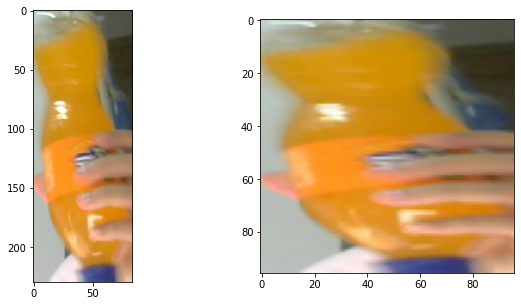

In [8]:
img_path='reallife_images/0/0.612563331998215.jpg'
img = Image.open(img_path)
resized_img=img.resize((96,96))
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
plt.imshow(img,aspect='equal')
ax2 = fig.add_subplot(122)
plt.imshow(resized_img)
plt.show()

我发现，在训练过程中，如果不对图片做检测&抠图，那么模型效果会受到背景影响很大。模型倾向于“背答案”，在真实应用的时候，一旦背景变化，效果会非常不稳定。这也验证了本项目“先检测+后识别”设想的合理性。

## Baseline模型的建立
### 模型建立
本文所要搭建的Baseline模型是采用的我在《表情识别》大作业中所采用的Baseline模型，并以此模型出发，去进行接下来的对比分析。

In [2]:
simple_model = Sequential()
# 第一层
# Put your code here
simple_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
simple_model.add(Conv2D(32, (3, 3), activation='relu'))
simple_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
# 第二层
# Put your code here
simple_model.add(Conv2D(64, (3, 3), activation='relu'))
simple_model.add(Conv2D(64, (3, 3), activation='relu'))
simple_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
# 第三层
# Put your code here
simple_model.add(Conv2D(128, (3, 3), activation='relu'))
simple_model.add(Conv2D(128, (3, 3), activation='relu'))
simple_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
simple_model.add(Flatten())
# 全连接层
# Put your code here
simple_model.add(Dense(1024, activation='relu'))
simple_model.add(Dropout(0.2))
simple_model.add(Dense(64, activation='relu'))
simple_model.add(Dropout(0.2))
simple_model.add(Dense(7, activation='softmax'))

simple_model.compile(loss = 'categorical_crossentropy',optimizer = Adam(),metrics=['accuracy'])

### 数据集的划分
为保证对比实验的公正，先对收集到的两个数据集分别按7：3：1划分成训练样本/验证样本/测试样本。 
具体做法是：我写了一个对每一个类别采取《统计调查与数据采集》课中学到的SRSWOR不放回随机抽样的函数，通过`shutil.copy`移动到trval_pics文件夹内。  
对于第一章提到的爬虫获取的数据集`cropped`，和自己通过摄像头录制并裁剪的数据集`reallife`，将它们放在trval_pics文件夹内，并分别在这两个文件夹里生成train/val/test三个文件夹。

In [65]:
def split_into_tvt(ori_dir,target_dir):
    categories=os.listdir(ori_dir)
    random.seed(100)
    for cat in categories:
        os.makedirs(f'{target_dir}\\train\\{cat}',exist_ok=True) #第一次移动需要创建，之后则不用
        os.makedirs(f'{target_dir}\\val\\{cat}',exist_ok=True)
        os.makedirs(f'{target_dir}\\test\\{cat}',exist_ok=True)
        tobe_moved=os.listdir(f'{ori_dir}\\{cat}')
        train,valtest=train_test_split(tobe_moved,test_size=0.3,random_state=100)
        val,test=train_test_split(valtest,test_size=1/3,random_state=100)
        for i in train:
            shutil.copy(f'{ori_dir}\\{cat}\\{i}',f'{target_dir}\\train\\{cat}')
        for i in val:
            shutil.copy(f'{ori_dir}\\{cat}\\{i}',f'{target_dir}\\val\\{cat}')
        for i in test:
            shutil.copy(f'{ori_dir}\\{cat}\\{i}',f'{target_dir}\\test\\{cat}')
split_into_tvt('reallife_images','trval_pics/reallife')
split_into_tvt('cropped_images','trval_pics/cropped')

### 模型训练
baseline模型的训练采用了`flow_from_directory`的方式，由于我从互联网采集/自己抠图得到的饮料瓶都不是规则的96x96大小，需要resize+reshape，且数据量大的情况下，将所有数据存放到内存中会显著降低效率，因此用`flow_from_directory`的方法训练。  
如之前所说，我采用了缩放到96x96的大小的图片进行训练，训练20个epoch，batch_size为32。  
分别对两个数据集建立模型进行训练。

In [3]:
#在爬虫采集到的数据上训练模型simple_model
def get_simple_model(traindir,testdir):
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
            traindir,
            target_size=(96, 96),
            batch_size=32,
            class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
            testdir,
            target_size=(96, 96),
            batch_size=32,
            class_mode='categorical')
    simple_model.compile(loss = 'categorical_crossentropy',optimizer = Adam(),metrics=['accuracy'])
    history=simple_model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples/train_generator.batch_size,
            epochs=40,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples/validation_generator.batch_size)
    return history,simple_model
history_crop,model_crop=get_simple_model(r'trval_pics/cropped/train',r'trval_pics/cropped/val')
history_reallife,model_reallife=get_simple_model(r'trval_pics/reallife/train',r'trval_pics/reallife/val')

Found 4640 images belonging to 7 classes.
Found 1328 images belonging to 7 classes.
Epoch 1/40
145/145 [==============================] - 4s 27ms/step - loss: 1.4147 - accuracy: 0.4746 - val_loss: 1.1063 - val_accuracy: 0.6250
Epoch 2/40
145/145 [==============================] - 4s 26ms/step - loss: 0.9500 - accuracy: 0.6787 - val_loss: 0.9265 - val_accuracy: 0.6845
Epoch 3/40
145/145 [==============================] - 4s 26ms/step - loss: 0.7918 - accuracy: 0.7388 - val_loss: 0.7699 - val_accuracy: 0.7500
Epoch 4/40
145/145 [==============================] - 4s 26ms/step - loss: 0.6818 - accuracy: 0.7649 - val_loss: 0.7128 - val_accuracy: 0.7583
Epoch 5/40
145/145 [==============================] - 4s 26ms/step - loss: 0.5821 - accuracy: 0.7961 - val_loss: 0.7683 - val_accuracy: 0.7417
Epoch 6/40
145/145 [==============================] - 4s 26ms/step - loss: 0.5337 - accuracy: 0.8110 - val_loss: 0.6709 - val_accuracy: 0.7892
Epoch 7/40
145/145 [==============================] - 4s 2

### 模型评估
我在给到我的画损失&画混淆矩阵的代码的基础上进行了一定的修改，并基于上面两个模型做了可视化。

In [4]:
def plot_loss_acc(history,model,test_dir):
    epochs=len(history.history['loss'])
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs2 = range(1,epochs+1)
    fig = plt.figure(figsize=(18,8))
    ax = fig.add_subplot(121)
    ax.plot(epochs2,loss,'b',label = 'Training Loss',alpha=0.2,linewidth = 3)
    ax.plot(epochs2,val_loss,'b',label='Validation Loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    ax2 = fig.add_subplot(122)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    ax2.plot(epochs2,acc,'b',label = 'Training Acc',alpha=0.2,linewidth = 3)
    ax2.plot(epochs2,val_acc,'b',label='Validation Acc')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
                test_dir,
                target_size=(96, 96),
                batch_size=32,
                class_mode='categorical')
    loss,test_acc=model.evaluate_generator(test_generator)
    print(f"best train,val,test acc is {round(max(history.history['accuracy'])*100,4)}% , {round(max(history.history['val_accuracy'])*100,4)}% and {round(test_acc*100,4)}%")

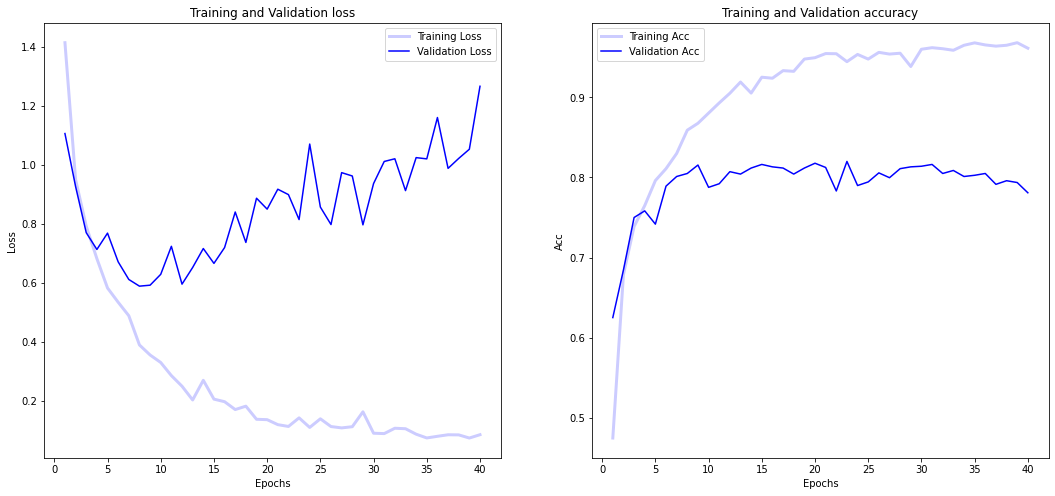

Found 667 images belonging to 7 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
best train,val,test acc is 96.8319% , 82.003% and 57.7211%


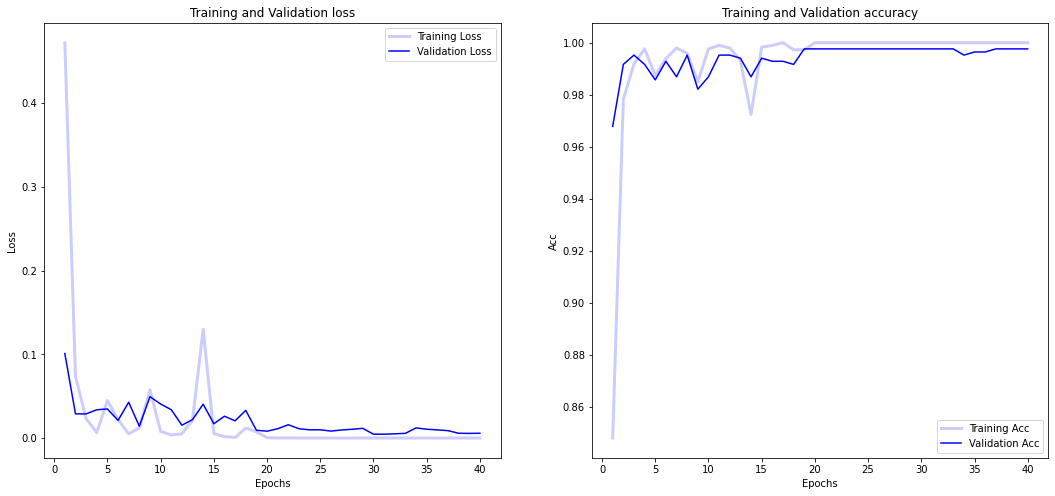

Found 422 images belonging to 7 classes.
best train,val,test acc is 100.0% , 99.7616% and 99.763%


In [5]:
plot_loss_acc(history_crop,model_crop,'trval_pics/cropped/test')
plot_loss_acc(history_reallife,model_reallife,'trval_pics/reallife/test')

**Model Performance Comparison**
- `cropped dataset` best train,val,test acc is 96.8319% , 82.003% and 57.7211%
- `reallife dataset` best train,val,test acc is 100.0% , 99.7616% and 99.763%


通过上图我们可以看出，由于样本质量的原因，在`cropped`数据集上的测试acc只有57%。这是因为`cropped`数据集中，有些类别的图片混入了其他的非相关饮料，这也解释了为何测试acc比验证acc低得多的原因。而`reallife`数据集由于样本质量很高的原因，训练、验证、测试acc都位于99%以上。

注意到，在7个饮料的类别中，我混入了颜色相近的冰红茶和果粒橙，以及形状相近的可乐和雪碧，而模型对于它们都分类的较好，说明该Baseline模型已经能够较好的提取特征，并具有较强的能力，但是稍微有些过拟合，这在接下来的章节中会进行探索。

至此，baseline模型建立完毕，接下来是对模型参数的调优。

## padding的选择
之所以考虑这个参数，是考虑到在这个商业场景中，我的所有训练都是用裁剪后的图片再Resize才进行训练的，因此对于图片四周的像素来说，在默认的padding方式下会被丢弃，因此有可能会降低效果。所以在下面的代码中，我调整padding方式为'same'来进行训练。

Found 4640 images belonging to 7 classes.
Found 1328 images belonging to 7 classes.
Epoch 1/40
145/145 [==============================] - 6s 43ms/step - loss: 1.3794 - accuracy: 0.4806 - val_loss: 1.0380 - val_accuracy: 0.6453
Epoch 2/40
145/145 [==============================] - 4s 28ms/step - loss: 0.9234 - accuracy: 0.6845 - val_loss: 0.8077 - val_accuracy: 0.7229
Epoch 3/40
145/145 [==============================] - 4s 28ms/step - loss: 0.7293 - accuracy: 0.7504 - val_loss: 0.8273 - val_accuracy: 0.7214
Epoch 4/40
145/145 [==============================] - 4s 27ms/step - loss: 0.5820 - accuracy: 0.7970 - val_loss: 0.6869 - val_accuracy: 0.7583
Epoch 5/40
145/145 [==============================] - 4s 27ms/step - loss: 0.4858 - accuracy: 0.8358 - val_loss: 0.7731 - val_accuracy: 0.7462
Epoch 6/40
145/145 [==============================] - 4s 27ms/step - loss: 0.3878 - accuracy: 0.8659 - val_loss: 0.5978 - val_accuracy: 0.7839
Epoch 7/40
145/145 [==============================] - 4s 2

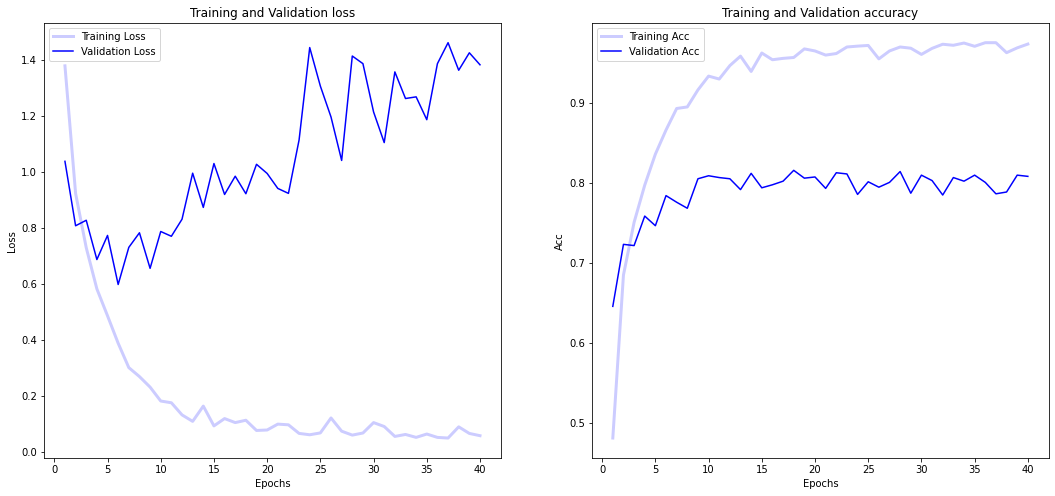

Found 667 images belonging to 7 classes.
best train,val,test acc is 97.5215% , 81.5512% and 54.4228%


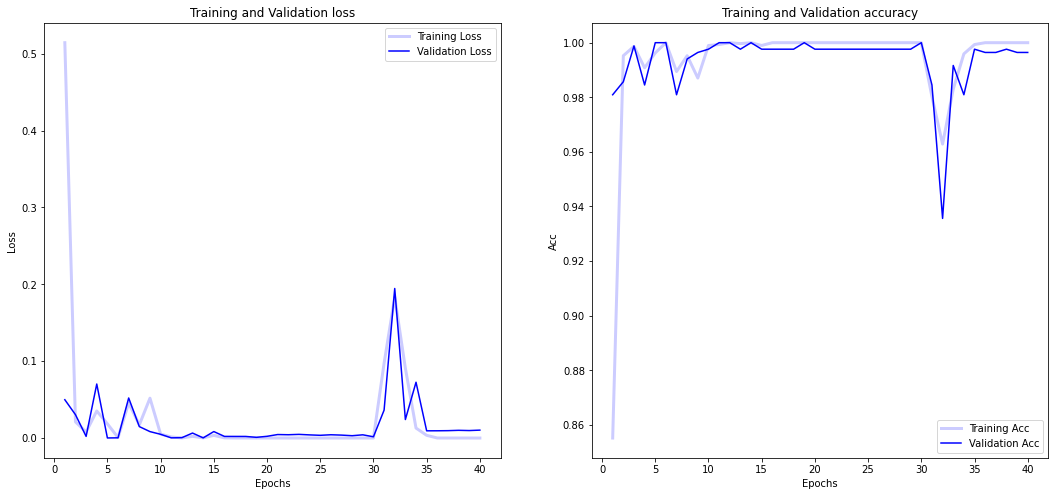

Found 422 images belonging to 7 classes.
best train,val,test acc is 100.0% , 100.0% and 99.763%


In [6]:
simple_model = Sequential()
# 第一层
# Put your code here
simple_model.add(Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(96, 96, 3)))
simple_model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
simple_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
# 第二层
# Put your code here
simple_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
simple_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
simple_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
# 第三层
# Put your code here
simple_model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
simple_model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
simple_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
simple_model.add(Flatten())
# 全连接层
# Put your code here
simple_model.add(Dense(1024, activation='relu'))
simple_model.add(Dropout(0.2))
simple_model.add(Dense(64, activation='relu'))
simple_model.add(Dropout(0.2))
simple_model.add(Dense(7, activation='softmax'))

simple_model.compile(loss = 'categorical_crossentropy',optimizer = Adam(),metrics=['accuracy'])

history_crop,model_crop=get_simple_model(r'trval_pics/cropped/train',r'trval_pics/cropped/val')
history_reallife,model_reallife=get_simple_model(r'trval_pics/reallife/train',r'trval_pics/reallife/val')

plot_loss_acc(history_crop,model_crop,'trval_pics/cropped/test')
plot_loss_acc(history_reallife,model_reallife,'trval_pics/reallife/test')

**Model Performance Comparison**
- Baseline Model
- `cropped dataset` best train,val,test acc is 96.8319% , 82.003% and 57.7211%
- `reallife dataset` best train,val,test acc is 100.0% , 99.7616% and 99.763%


- padding changed to 'same'
- `cropped dataset` best train,val,test acc is 97.5215% , 81.5512% and 54.4228%
- `reallife dataset` best train,val,test acc is 100.0% , 100.0% and 99.763%

从结果来看，改变padding方式并没有像设想的一样在这个问题上带来改观，反而是在`cropped`数据集上带来了一定的下降，在`reallife`数据集上有一个剧烈的波动。我分析这一现象的原因可能是：YOLOX检测模型所检测到并截取的图片周围是真实的背景，而这些背景是有意义的。如果采取padding='same'，即对输入图像的周围添加像素，这可能会引入一定的bias，因此导致这一现象。

## 激活函数的选择
由于我想测试各种激活函数的效果，通过课程的学习，我已经知道了sigmoid和tanh都不如relu效果好，因此我想试一下LeakyReLU,ELU的效果，以及比较它们的收敛速度。  

Found 4640 images belonging to 7 classes.
Found 1328 images belonging to 7 classes.
Epoch 1/40
145/145 [==============================] - 4s 31ms/step - loss: 1.2013 - accuracy: 0.5679 - val_loss: 0.9237 - val_accuracy: 0.6860
Epoch 2/40
145/145 [==============================] - 4s 29ms/step - loss: 0.8310 - accuracy: 0.7084 - val_loss: 0.8940 - val_accuracy: 0.6807
Epoch 3/40
145/145 [==============================] - 4s 29ms/step - loss: 0.7175 - accuracy: 0.7513 - val_loss: 0.7502 - val_accuracy: 0.7236
Epoch 4/40
145/145 [==============================] - 4s 30ms/step - loss: 0.6235 - accuracy: 0.7830 - val_loss: 0.6603 - val_accuracy: 0.7673
Epoch 5/40
145/145 [==============================] - 4s 29ms/step - loss: 0.5187 - accuracy: 0.8138 - val_loss: 0.6777 - val_accuracy: 0.7718
Epoch 6/40
145/145 [==============================] - 4s 29ms/step - loss: 0.4739 - accuracy: 0.8233 - val_loss: 0.7335 - val_accuracy: 0.7620
Epoch 7/40
145/145 [==============================] - 4s 2

Epoch 17/40
92/91 [==============================] - 3s 29ms/step - loss: 7.8146e-05 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 0.9964
Epoch 18/40
92/91 [==============================] - 3s 31ms/step - loss: 8.7700e-05 - accuracy: 1.0000 - val_loss: 0.0199 - val_accuracy: 0.9964
Epoch 19/40
92/91 [==============================] - 3s 31ms/step - loss: 7.8825e-05 - accuracy: 1.0000 - val_loss: 0.0219 - val_accuracy: 0.9940
Epoch 20/40
92/91 [==============================] - 3s 28ms/step - loss: 5.3279e-05 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9940
Epoch 21/40
92/91 [==============================] - 3s 28ms/step - loss: 4.7472e-06 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 0.9940
Epoch 22/40
92/91 [==============================] - 3s 28ms/step - loss: 5.4684e-05 - accuracy: 1.0000 - val_loss: 0.0164 - val_accuracy: 0.9940
Epoch 23/40
92/91 [==============================] - 3s 29ms/step - loss: 8.7446e-05 - accuracy: 1.0000 - val_loss: 0.0123 -

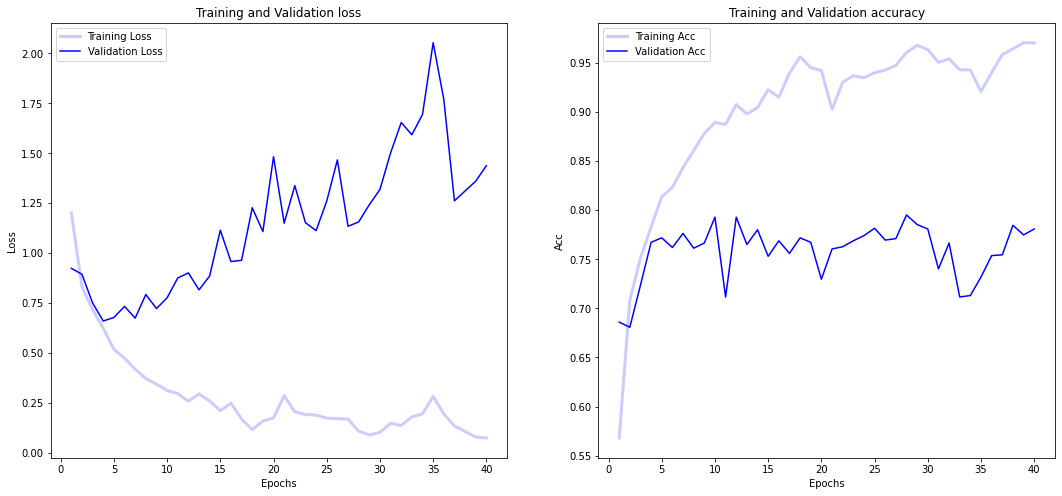

Found 667 images belonging to 7 classes.
best train,val,test acc is 97.069% , 79.5181% and 58.7706%


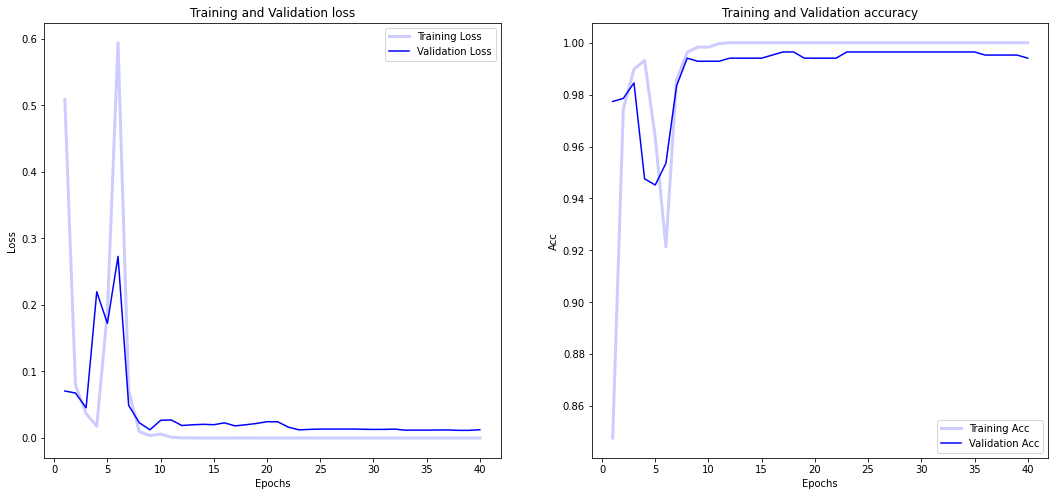

Found 422 images belonging to 7 classes.
best train,val,test acc is 100.0% , 99.6424% and 99.5261%
Found 4640 images belonging to 7 classes.
Found 1328 images belonging to 7 classes.
Epoch 1/40
145/145 [==============================] - 4s 28ms/step - loss: 1.9265 - accuracy: 0.4981 - val_loss: 1.0691 - val_accuracy: 0.6318
Epoch 2/40
145/145 [==============================] - 4s 27ms/step - loss: 0.9838 - accuracy: 0.6655 - val_loss: 0.9545 - val_accuracy: 0.6649
Epoch 3/40
145/145 [==============================] - 4s 27ms/step - loss: 0.8103 - accuracy: 0.7147 - val_loss: 0.7663 - val_accuracy: 0.7492
Epoch 4/40
145/145 [==============================] - 4s 27ms/step - loss: 0.7024 - accuracy: 0.7545 - val_loss: 0.7544 - val_accuracy: 0.7470
Epoch 5/40
145/145 [==============================] - 4s 26ms/step - loss: 0.6160 - accuracy: 0.7804 - val_loss: 0.7445 - val_accuracy: 0.7477
Epoch 6/40
145/145 [==============================] - 4s 26ms/step - loss: 0.5564 - accuracy: 0.8004 -

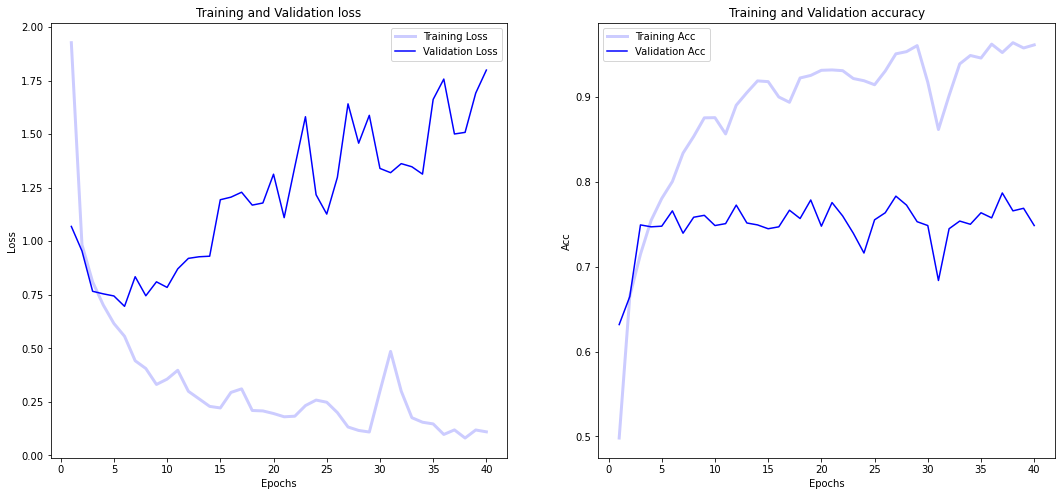

Found 667 images belonging to 7 classes.
best train,val,test acc is 96.4009% , 78.6898% and 15.2924%


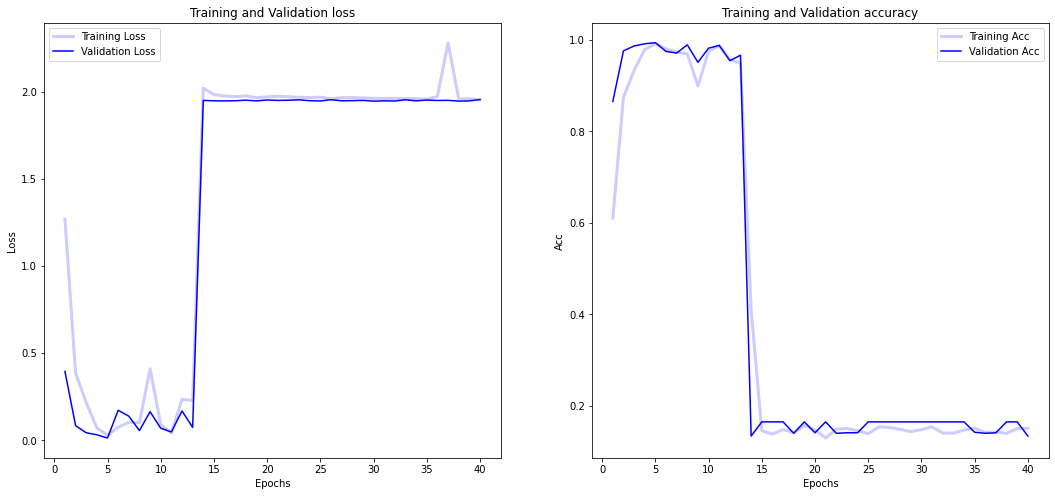

Found 422 images belonging to 7 classes.
best train,val,test acc is 99.1823% , 99.4041% and 13.5071%


In [7]:
def get_model(act):
    simple_model = Sequential()
    simple_model.add(Conv2D(32, (3, 3), activation=act, input_shape=(96, 96, 3)))
    simple_model.add(Conv2D(32, (3, 3), activation=act))
    simple_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    simple_model.add(Conv2D(64, (3, 3), activation=act))
    simple_model.add(Conv2D(64, (3, 3), activation=act))
    simple_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    simple_model.add(Conv2D(128, (3, 3), activation=act))
    simple_model.add(Conv2D(128, (3, 3), activation=act))
    simple_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    simple_model.add(Flatten())
    simple_model.add(Dense(1024, activation=act))
    simple_model.add(Dropout(0.2))
    simple_model.add(Dense(64, activation=act))
    simple_model.add(Dropout(0.2))
    simple_model.add(Dense(7, activation='softmax'))
    return simple_model
simple_model=get_model(LeakyReLU())
history_crop,model_crop=get_simple_model(r'trval_pics/cropped/train',r'trval_pics/cropped/val')
history_reallife,model_reallife=get_simple_model(r'trval_pics/reallife/train',r'trval_pics/reallife/val')
plot_loss_acc(history_crop,model_crop,'trval_pics/cropped/test')
plot_loss_acc(history_reallife,model_reallife,'trval_pics/reallife/test')

simple_model=get_model(ELU())
history_crop,model_crop=get_simple_model(r'trval_pics/cropped/train',r'trval_pics/cropped/val')
history_reallife,model_reallife=get_simple_model(r'trval_pics/reallife/train',r'trval_pics/reallife/val')
plot_loss_acc(history_crop,model_crop,'trval_pics/cropped/test')
plot_loss_acc(history_reallife,model_reallife,'trval_pics/reallife/test')

**Model Performance Comparison**
- Baseline Model
- `cropped dataset` best train,val,test acc is 96.8319% , 82.003% and 57.7211%
- `reallife dataset` best train,val,test acc is 100.0% , 99.7616% and 99.763%


- Activation changed to 'LeakyRelu'
- `cropped dataset` best train,val,test acc is 97.069% , 79.5181% and 58.7706%
- `reallife dataset` best train,val,test acc is 100.0% , 99.6424% and 99.5261%

- Activation changed to 'ELU'
- `cropped dataset` best train,val,test acc is 96.4009% , 78.6898% and 15.2924%
- `reallife dataset` best train,val,test acc is 99.1823% , 99.4041% and 13.5071%


从图像来看，在使用LeakyRelu的`reallife`数据集上的第3~8个epoch存在损失上升的情况，说明模型试图从局部最优点中出来，然后再第15个epoch之后慢慢走向平衡，最终取得的模型在训练，测试集合上均比baseline要高，而验证集略低。

而ELU在`reallife`数据集上陷入了局部最优点，而且ELU无法走出局部最优点，也正因为这样，ELU最后在测试集上的准确率很低，这也许是一个巧合，总之，根据实验结果而言，我不建议使用该激活函数。

## batch size的选择
由于我想测试各种batch_size的效果，以及比较它们的收敛速度。这一次的图像都是96x96，因此可以在自己的单卡上选用一个较高的batch size。baseline选用的batch size为32，在这里我测试batch size的取值为16，64两种。

Found 4640 images belonging to 7 classes.
Found 1328 images belonging to 7 classes.
Epoch 1/40
290/290 [==============================] - 4s 15ms/step - loss: 1.3760 - accuracy: 0.4931 - val_loss: 1.1579 - val_accuracy: 0.6197
Epoch 2/40
290/290 [==============================] - 4s 14ms/step - loss: 0.9390 - accuracy: 0.6761 - val_loss: 0.8223 - val_accuracy: 0.7131
Epoch 3/40
290/290 [==============================] - 4s 14ms/step - loss: 0.7895 - accuracy: 0.7356 - val_loss: 0.6907 - val_accuracy: 0.7651
Epoch 4/40
290/290 [==============================] - 4s 14ms/step - loss: 0.6589 - accuracy: 0.7823 - val_loss: 0.7839 - val_accuracy: 0.7492
Epoch 5/40
290/290 [==============================] - 4s 14ms/step - loss: 0.5975 - accuracy: 0.7978 - val_loss: 0.6241 - val_accuracy: 0.7764
Epoch 6/40
290/290 [==============================] - 4s 14ms/step - loss: 0.5145 - accuracy: 0.8159 - val_loss: 0.5813 - val_accuracy: 0.7861
Epoch 7/40
290/290 [==============================] - 4s 1

Epoch 17/40
184/183 [==============================] - 3s 17ms/step - loss: 1.2526e-05 - accuracy: 1.0000 - val_loss: 0.0083 - val_accuracy: 0.9988
Epoch 18/40
184/183 [==============================] - 3s 14ms/step - loss: 1.5131e-05 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 0.9988
Epoch 19/40
184/183 [==============================] - 3s 14ms/step - loss: 1.8969e-05 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 0.9988
Epoch 20/40
184/183 [==============================] - 3s 14ms/step - loss: 3.7222e-06 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9988
Epoch 21/40
184/183 [==============================] - 3s 16ms/step - loss: 6.3597e-06 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9988
Epoch 22/40
184/183 [==============================] - 3s 14ms/step - loss: 0.0188 - accuracy: 0.9963 - val_loss: 0.0883 - val_accuracy: 0.9869
Epoch 23/40
184/183 [==============================] - 2s 14ms/step - loss: 0.4271 - accuracy: 0.9257 - val_loss: 0.

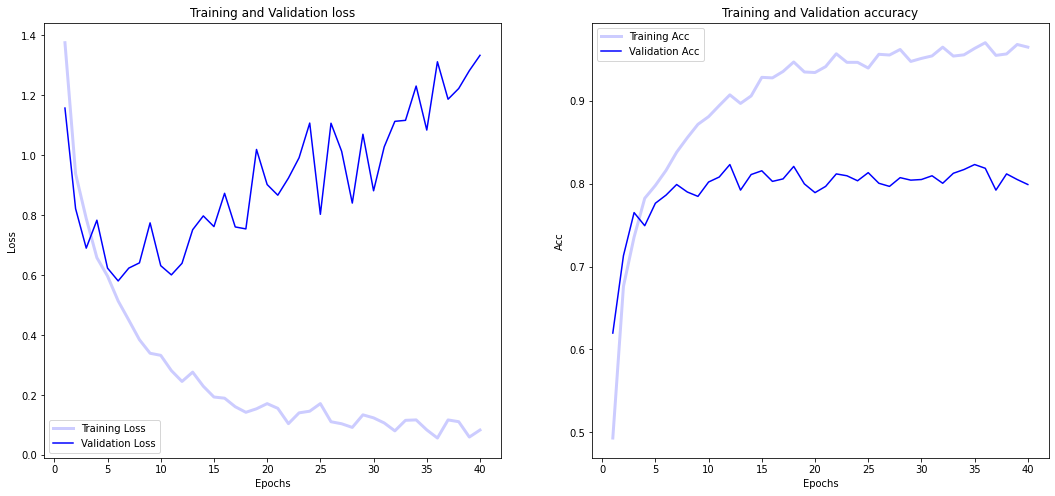

Found 667 images belonging to 7 classes.
best train,val,test acc is 97.0043% , 82.3042% and 50.3748%


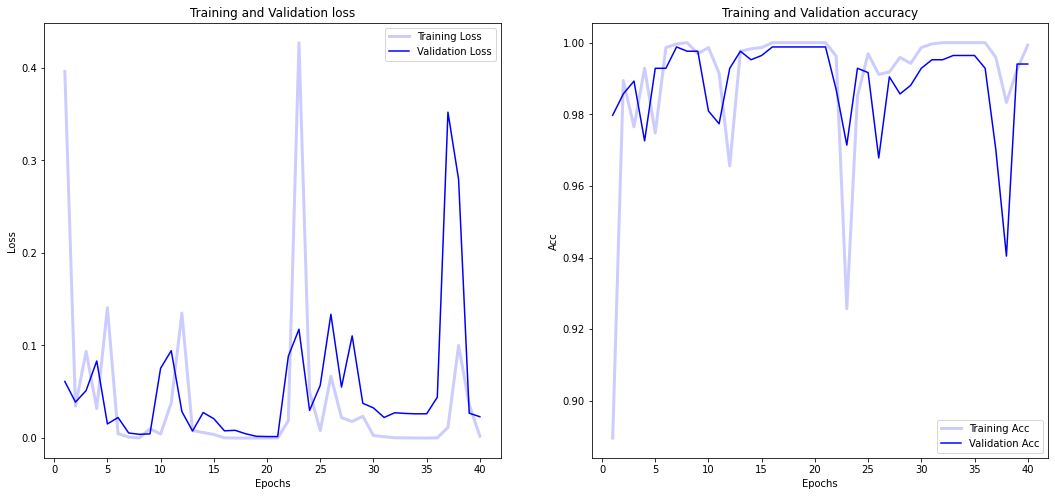

Found 422 images belonging to 7 classes.
best train,val,test acc is 100.0% , 99.8808% and 99.2891%
Found 4640 images belonging to 7 classes.
Found 1328 images belonging to 7 classes.
Epoch 1/40
73/72 [==============================] - 4s 53ms/step - loss: 1.6184 - accuracy: 0.3582 - val_loss: 1.1928 - val_accuracy: 0.5971
Epoch 2/40
73/72 [==============================] - 4s 52ms/step - loss: 1.1082 - accuracy: 0.6183 - val_loss: 0.9645 - val_accuracy: 0.6883
Epoch 3/40
73/72 [==============================] - 4s 51ms/step - loss: 0.8987 - accuracy: 0.6873 - val_loss: 0.8798 - val_accuracy: 0.7018
Epoch 4/40
73/72 [==============================] - 4s 53ms/step - loss: 0.7711 - accuracy: 0.7379 - val_loss: 0.7638 - val_accuracy: 0.7372
Epoch 5/40
73/72 [==============================] - 4s 51ms/step - loss: 0.6930 - accuracy: 0.7664 - val_loss: 0.7069 - val_accuracy: 0.7538
Epoch 6/40
73/72 [==============================] - 4s 52ms/step - loss: 0.6015 - accuracy: 0.7931 - val_loss: 0

Epoch 15/40
46/45 [==============================] - 2s 44ms/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.0228 - val_accuracy: 0.9940
Epoch 16/40
46/45 [==============================] - 2s 44ms/step - loss: 0.0834 - accuracy: 0.9806 - val_loss: 0.0389 - val_accuracy: 0.9905
Epoch 17/40
46/45 [==============================] - 2s 44ms/step - loss: 0.0185 - accuracy: 0.9945 - val_loss: 0.0354 - val_accuracy: 0.9857
Epoch 18/40
46/45 [==============================] - 2s 45ms/step - loss: 0.0078 - accuracy: 0.9980 - val_loss: 0.0071 - val_accuracy: 0.9964
Epoch 19/40
46/45 [==============================] - 2s 45ms/step - loss: 0.0328 - accuracy: 0.9932 - val_loss: 0.0138 - val_accuracy: 0.9940
Epoch 20/40
46/45 [==============================] - 2s 44ms/step - loss: 0.0056 - accuracy: 0.9990 - val_loss: 0.0069 - val_accuracy: 0.9988
Epoch 21/40
46/45 [==============================] - 2s 44ms/step - loss: 7.9874e-04 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9976
Ep

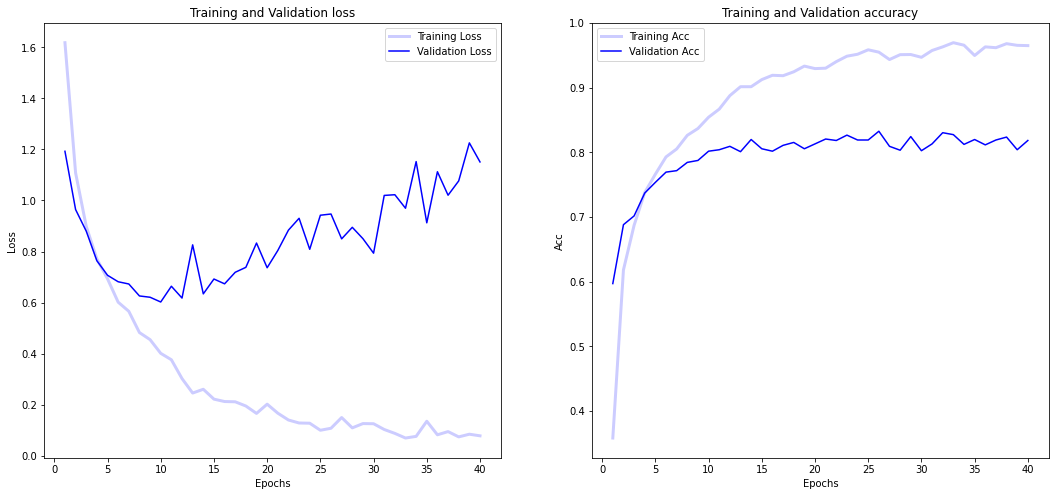

Found 667 images belonging to 7 classes.
best train,val,test acc is 96.9828% , 83.2831% and 54.1229%


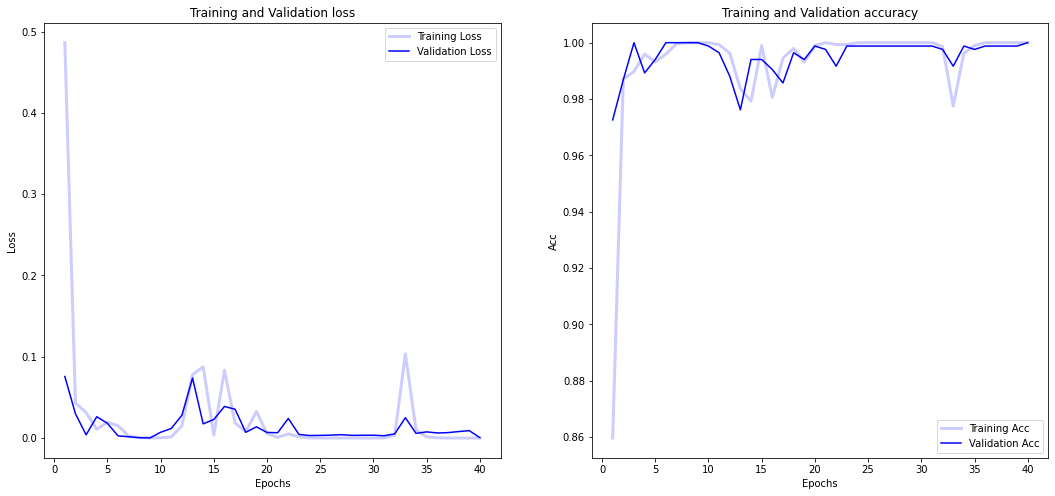

Found 422 images belonging to 7 classes.
best train,val,test acc is 100.0% , 100.0% and 100.0%


In [8]:
def get_simple_model(traindir,testdir,batchsize):
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
            traindir,
            target_size=(96, 96),
            batch_size=batchsize,
            class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
            testdir,
            target_size=(96, 96),
            batch_size=batchsize,
            class_mode='categorical')
    simple_model.compile(loss = 'categorical_crossentropy',optimizer = Adam(),metrics=['accuracy'])
    history=simple_model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples/train_generator.batch_size,
            epochs=40,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples/validation_generator.batch_size)
    return history,simple_model
simple_model=get_model('relu')
history_crop,model_crop=get_simple_model(r'trval_pics/cropped/train',r'trval_pics/cropped/val',16)
history_reallife,model_reallife=get_simple_model(r'trval_pics/reallife/train',r'trval_pics/reallife/val',16)
plot_loss_acc(history_crop,model_crop,'trval_pics/cropped/test')
plot_loss_acc(history_reallife,model_reallife,'trval_pics/reallife/test')

simple_model=get_model('relu')
history_crop,model_crop=get_simple_model(r'trval_pics/cropped/train',r'trval_pics/cropped/val',64)
history_reallife,model_reallife=get_simple_model(r'trval_pics/reallife/train',r'trval_pics/reallife/val',64)
plot_loss_acc(history_crop,model_crop,'trval_pics/cropped/test')
plot_loss_acc(history_reallife,model_reallife,'trval_pics/reallife/test')

- Baseline Model
- `cropped dataset` best train,val,test acc is 97.8664% , 82.6054% and 79.1604%
- `reallife dataset` best train,val,test acc is 98.2543% , 82.9066% and 35.545%


- batchsize changed to '16'
- `cropped dataset` best train,val,test acc is 97.0043% , 82.3042% and 50.3748%
- `reallife dataset` best train,val,test acc is 100.0% , 99.8808% and 99.2891%

- batchsize changed to '64'
- `cropped dataset` best train,val,test acc is 96.9828% , 83.2831% and 54.1229%
- `reallife dataset` best train,val,test acc is 100.0% , 100.0% and 100.0%


从图像来看，batchsize为16的模型在训练过程中波动非常严重，而batchsize为32和64的模型则相对稳定。这是符合预期的，因为batchsize小的时候，模型非常容易在单个epoch的训练过程中跳出当前的全局最优点，因此造成较大的波动；而随着模型的继续训练，模型又会重新回到全局最优点，因此造成了如此大波动的现象。

从准确率来看，实验结果显示，大batch size在通常会带来更好的结果。

## 优化器的选择
在《统计计算》课程的前半部分，刚好也讲过各种优化算法，可惜有些算法（例如牛顿、坐标下降）并不是深度学习所采用的，原因是深度学习是一个非凸优化问题，因此传统上而言SGD的效果最好。Baseline使用的是公认最好的Adam优化器，因此在这里进行试验，对比带nesterov的SGD和Adam(baseline)的效果。

Found 4640 images belonging to 7 classes.
Found 1328 images belonging to 7 classes.
Epoch 1/40
145/145 [==============================] - 4s 28ms/step - loss: 1.8956 - accuracy: 0.2416 - val_loss: 1.8355 - val_accuracy: 0.2485
Epoch 2/40
145/145 [==============================] - 4s 27ms/step - loss: 1.7192 - accuracy: 0.3784 - val_loss: 1.5434 - val_accuracy: 0.4307
Epoch 3/40
145/145 [==============================] - 4s 27ms/step - loss: 1.4986 - accuracy: 0.4606 - val_loss: 1.3694 - val_accuracy: 0.5497
Epoch 4/40
145/145 [==============================] - 4s 27ms/step - loss: 1.3682 - accuracy: 0.5254 - val_loss: 1.2728 - val_accuracy: 0.5459
Epoch 5/40
145/145 [==============================] - 4s 27ms/step - loss: 1.2694 - accuracy: 0.5571 - val_loss: 1.2015 - val_accuracy: 0.5949
Epoch 6/40
145/145 [==============================] - 4s 27ms/step - loss: 1.2051 - accuracy: 0.5789 - val_loss: 1.1306 - val_accuracy: 0.6212
Epoch 7/40
145/145 [==============================] - 4s 2

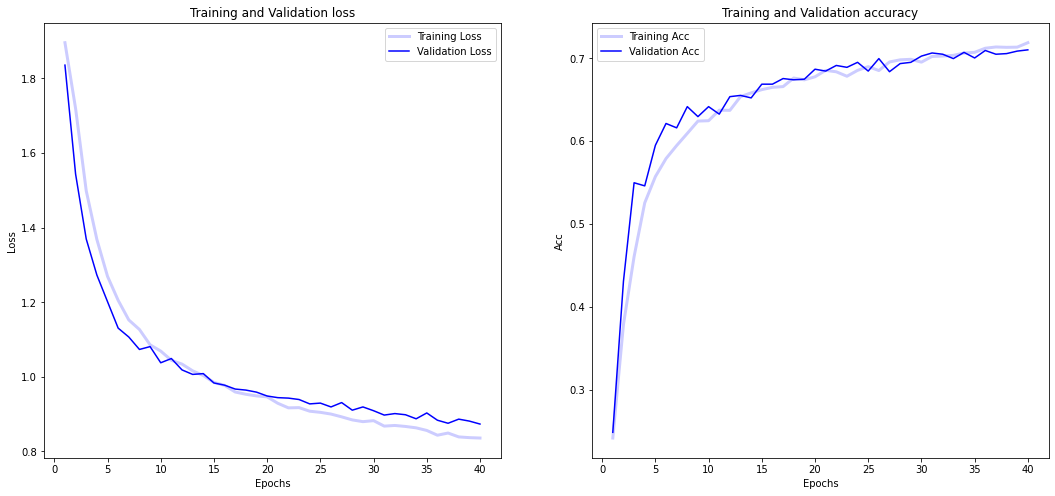

Found 667 images belonging to 7 classes.
best train,val,test acc is 71.875% , 71.009% and 31.7841%


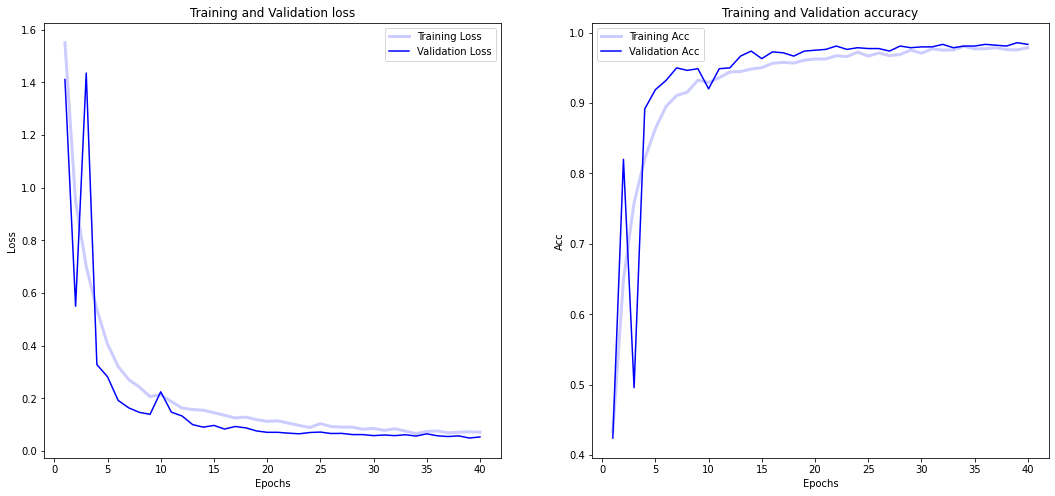

Found 422 images belonging to 7 classes.
best train,val,test acc is 98.0579% , 98.5697% and 98.1043%


In [9]:
def get_simple_model(traindir,testdir,batchsize):
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
            traindir,
            target_size=(96, 96),
            batch_size=batchsize,
            class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
            testdir,
            target_size=(96, 96),
            batch_size=batchsize,
            class_mode='categorical')
    simple_model.compile(loss = 'categorical_crossentropy',optimizer = SGD(momentum=0.1, decay=0.01, nesterov=False),metrics=['accuracy'])
    history=simple_model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples/train_generator.batch_size,
            epochs=40,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples/validation_generator.batch_size)
    return history,simple_model
simple_model=get_model('relu')
history_crop,model_crop=get_simple_model(r'trval_pics/cropped/train',r'trval_pics/cropped/val',32)
history_reallife,model_reallife=get_simple_model(r'trval_pics/reallife/train',r'trval_pics/reallife/val',32)
plot_loss_acc(history_crop,model_crop,'trval_pics/cropped/test')
plot_loss_acc(history_reallife,model_reallife,'trval_pics/reallife/test')

- Baseline Model --Adam
- `cropped dataset` best train,val,test acc is 97.8664% , 82.6054% and 79.1604%
- `reallife dataset` best train,val,test acc is 98.2543% , 82.9066% and 35.545%


- batchsize changed to '16' --SGD Nesterov
- `cropped dataset` best train,val,test acc is 71.875% , 71.009% and 31.7841%
- `reallife dataset` best train,val,test acc is 98.0579% , 98.5697% and 98.1043%



从图像来看，带Nesterov的SGD的训练非常稳定，这是符合预期的，因为带有动量的模型，根据动量的思想，会带有原先方向的动量，尤其是Nesterove动量，可以将“未来的动量”当作当前的动量，因此会很稳定。

从准确率来看，实验结果显示，SGD Nesterov不如Adam的效果好，这也是大家均选取Adam的原因。

## 数据增强的效果

Found 4640 images belonging to 7 classes.
Found 1328 images belonging to 7 classes.
Epoch 1/40
145/145 [==============================] - 11s 75ms/step - loss: 1.4040 - accuracy: 0.4834 - val_loss: 1.1456 - val_accuracy: 0.6175
Epoch 2/40
145/145 [==============================] - 11s 75ms/step - loss: 1.0870 - accuracy: 0.6190 - val_loss: 1.0467 - val_accuracy: 0.6280
Epoch 3/40
145/145 [==============================] - 11s 74ms/step - loss: 0.9685 - accuracy: 0.6694 - val_loss: 0.8946 - val_accuracy: 0.7041
Epoch 4/40
145/145 [==============================] - 11s 74ms/step - loss: 0.8810 - accuracy: 0.6933 - val_loss: 0.8823 - val_accuracy: 0.7206
Epoch 5/40
145/145 [==============================] - 12s 80ms/step - loss: 0.8052 - accuracy: 0.7338 - val_loss: 0.7668 - val_accuracy: 0.7372
Epoch 6/40
145/145 [==============================] - 11s 75ms/step - loss: 0.7400 - accuracy: 0.7481 - val_loss: 0.6806 - val_accuracy: 0.7636
Epoch 7/40
145/145 [==============================] 

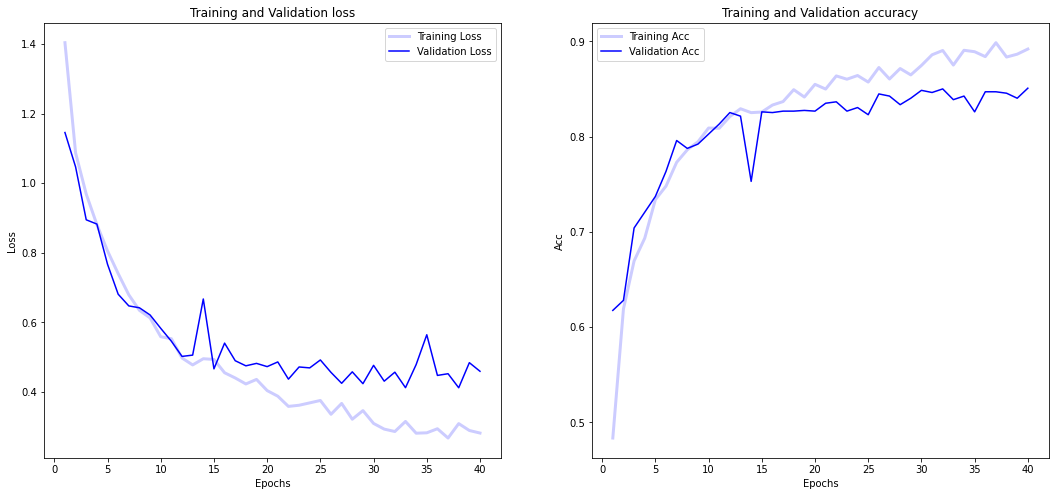

Found 667 images belonging to 7 classes.
best train,val,test acc is 89.8707% , 85.0904% and 46.4768%


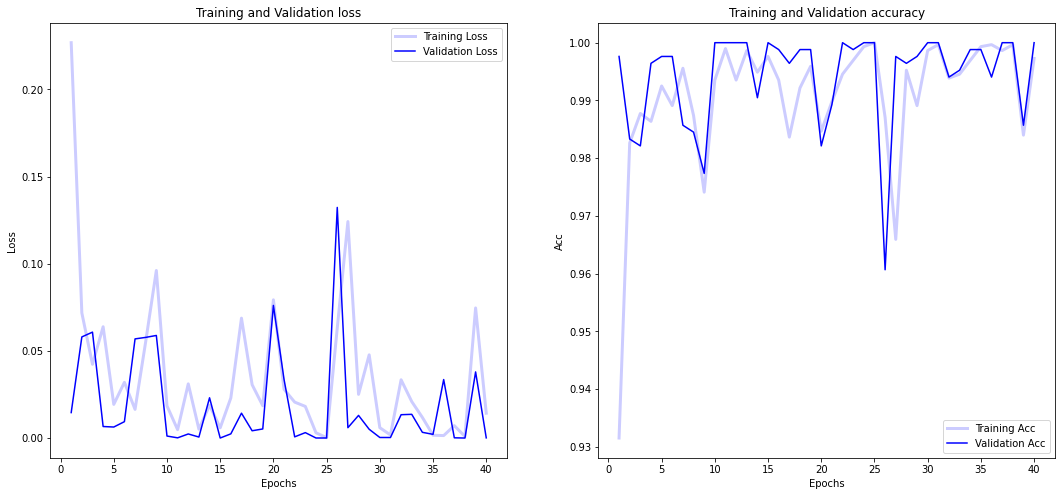

Found 422 images belonging to 7 classes.
best train,val,test acc is 100.0% , 100.0% and 100.0%


In [10]:
def get_simple_model(traindir,testdir,batchsize):
    train_datagen = ImageDataGenerator(    
                        rotation_range=20,
                        rescale=1./255,
                        shear_range=0.2,
                        zoom_range=0.2,
                        fill_mode='nearest',
                        height_shift_range=0.05, 
                        width_shift_range=0.1,
                        horizontal_flip=True
                    )
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
            traindir,
            target_size=(96, 96),
            batch_size=batchsize,
            class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
            testdir,
            target_size=(96, 96),
            batch_size=batchsize,
            class_mode='categorical')
    simple_model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics=['accuracy'])
    history=simple_model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples/train_generator.batch_size,
            epochs=40,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples/validation_generator.batch_size)
    return history,simple_model
simple_model=get_model('relu')
history_crop,model_crop=get_simple_model(r'trval_pics/cropped/train',r'trval_pics/cropped/val',32)
history_reallife,model_reallife=get_simple_model(r'trval_pics/reallife/train',r'trval_pics/reallife/val',32)
plot_loss_acc(history_crop,model_crop,'trval_pics/cropped/test')
plot_loss_acc(history_reallife,model_reallife,'trval_pics/reallife/test')

- Baseline Model 
- `cropped dataset` best train,val,test acc is 97.8664% , 82.6054% and 79.1604%
- `reallife dataset` best train,val,test acc is 98.2543% , 82.9066% and 35.545%


- Data Augmented Model
- `cropped dataset` best train,val,test acc is 89.8707% , 85.0904% and 46.4768%
- `reallife dataset` best train,val,test acc is 100.0% , 100.0% and 100.0%

从图像看，带有图像增强的模型较为不稳定，这也是符合预期的，正是因为引入了随机性，使模型学到了更有泛化性的结果。

从结果看，即使`crooped`数据集中有错误的图片，结果显示在训练集的准确率下降，验证集上的准确率上升，过拟合问题得到了解决。而`reallife`数据集更是达到了100%的训练&验证准确率，因此数据增强对抑制过拟合、提升泛化性的效果显著。

## 成熟模型的效果

Found 4640 images belonging to 7 classes.
Found 1328 images belonging to 7 classes.
Epoch 1/40
145/145 [==============================] - 72s 500ms/step - loss: 1.2057 - accuracy: 0.5892 - val_loss: 3.3719 - val_accuracy: 0.1739
Epoch 2/40
145/145 [==============================] - 45s 310ms/step - loss: 0.7748 - accuracy: 0.7263 - val_loss: 2.2881 - val_accuracy: 0.1815
Epoch 3/40
145/145 [==============================] - 42s 288ms/step - loss: 0.6148 - accuracy: 0.7685 - val_loss: 1.9143 - val_accuracy: 0.2726
Epoch 4/40
145/145 [==============================] - 41s 284ms/step - loss: 0.5610 - accuracy: 0.7832 - val_loss: 3.5695 - val_accuracy: 0.1747
Epoch 5/40
145/145 [==============================] - 41s 284ms/step - loss: 0.5340 - accuracy: 0.7994 - val_loss: 1.3793 - val_accuracy: 0.4571
Epoch 6/40
145/145 [==============================] - 41s 284ms/step - loss: 0.5484 - accuracy: 0.7881 - val_loss: 0.9163 - val_accuracy: 0.6950
Epoch 7/40
145/145 [==========================

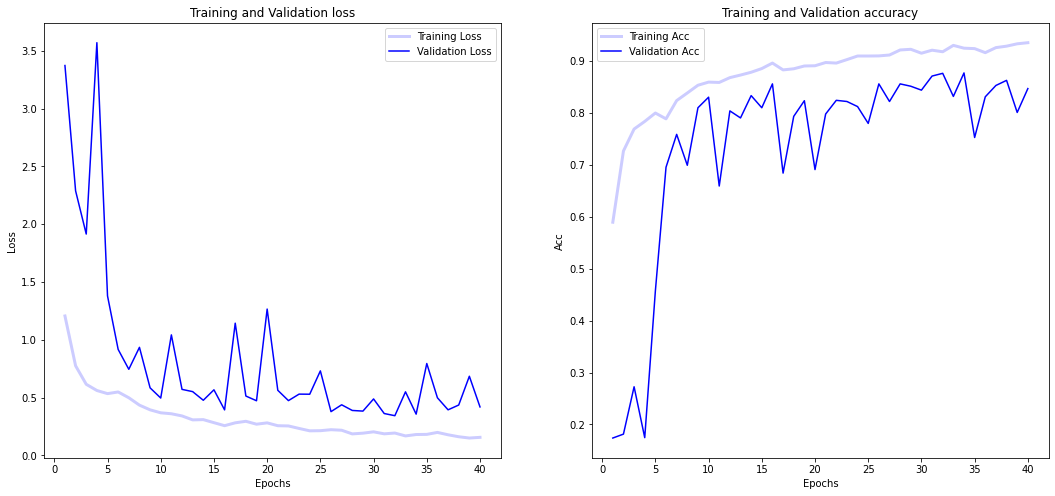

Found 667 images belonging to 7 classes.
best train,val,test acc is 93.4698% , 87.6506% and 51.4243%


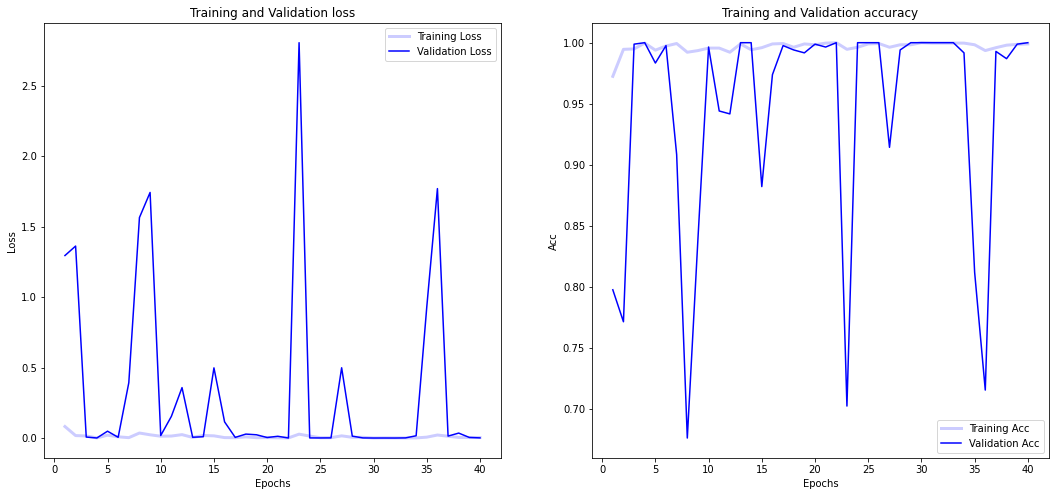

Found 422 images belonging to 7 classes.
best train,val,test acc is 100.0% , 100.0% and 94.3128%


In [15]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(7, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=predictions)
def get_simple_model(traindir,testdir,batchsize,model):
    train_datagen = ImageDataGenerator(    
                        rotation_range=20,
                        rescale=1./255,
                        shear_range=0.2,
                        zoom_range=0.2,
                        fill_mode='nearest',
                        height_shift_range=0.05, 
                        width_shift_range=0.1,
                        horizontal_flip=True
                    )
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
            traindir,
            target_size=(224, 224), #预训练网络要求244x244的输入
            batch_size=batchsize,
            class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
            testdir,
            target_size=(224, 224), #预训练网络要求244x244的输入
            batch_size=batchsize,
            class_mode='categorical')
    model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics=['accuracy'])
    history=model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples/train_generator.batch_size,
            epochs=40,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples/validation_generator.batch_size)
    return history,model
    
history_crop,model_crop=get_simple_model(r'trval_pics/cropped/train',r'trval_pics/cropped/val',32, model)
history_reallife,model_reallife=get_simple_model(r'trval_pics/reallife/train',r'trval_pics/reallife/val',32, model)
plot_loss_acc(history_crop,model_crop,'trval_pics/cropped/test')
plot_loss_acc(history_reallife,model_reallife,'trval_pics/reallife/test')

- Baseline Model 
- `cropped dataset` best train,val,test acc is 97.8664% , 82.6054% and 79.1604%
- `reallife dataset` best train,val,test acc is 98.2543% , 82.9066% and 35.545%

- Finetuned Model
- `cropped dataset` best train,val,test acc is 93.4698% , 87.6506% and 51.4243%
- `reallife dataset` best train,val,test acc is 100.0% , 100.0% and 94.3128%

从图像看，训练迁移模型较为不稳定，这也是符合预期的，因为只训练全连接层，且有dropout存在，所以会出现不稳定的现象。

从结果看，即使`crooped`数据集中有错误的图片，结果显示在验证集上迁移模型超过了2.7数据增强的效果。

## 小结
基于以上实验过程，我详细解释选择每个模型的原因，且与相关的 Baseline 模型的应用效果进行了对比分析，也对使用的深度学习模型进行了调参，并没有不是直接拿来应用。

这里我需要对部分实验的test_set acc低的原因做一下解释：我调查后发现是test set中数据样本过少，且模型过度拟合的原因。因此大部分实验还是用train/val set进行对比的。


综合各个实验结果，且考虑到实时检测的高时效性与准确率的要求，我最终选择了使用数据增强的模型，作为最终上线的模型。
```python
simple_model.save('assets/simple_model') #保存模型至 项目地址/assets/simple_model目录下
```

# 解决方案的构建
目前，我已经把整个demo做出来并实地验证了，演示视频请见视频b站地址。https://www.bilibili.com/video/BV1iU4y1K7ey/

本解决方案的搭建可以分为一下几个步骤：
- 1.使用YOLOX预训练模型实时检测出“饮料瓶”这一个类别
- 2.抠出检测到的饮料瓶图片，对它resize+reshape，再传入第二章所训练的分类网络进行分类。
- 3.实时调用摄像头，对每一帧的图片都进行step1~2的两阶段检测+识别模型调用，并设计判断物体取出的算法。
- 4.搭建前端界面，用户可以通过“傻瓜式”的点击登陆&模拟真实的智能货柜的操作。
- 5.搭建后端系统，在用户无感地购买商品后，计算出总价。并结合前半部分课的数据库操作，写入mysql数据库。

遇到并解决的难点技术问题：
- 在原YOLOX项目的基础上环境配置、调通代码、理清楚数据传递、修改后处理等等工作。
- YOLOX使用pytorch框架，而我的模型是基于课上教的keras的，即使在我解决环境配置问题后，仍然发现：当两者串行调用时，程序会自动崩溃，而不显示任何错误信息。在验证多个猜想后，我推测是两者抢GPU资源的问题，因此把keras模型放在CPU上运行，此时两者可以同时工作；更新一步：我发现，tensorflow一旦开始基于GPU的预测，会自动抢占所有GPU的资源，导致pytorch无资源可用，进而崩溃。因此我查到了可以通过限制内存增长的方式，让tensorflow只用它需要的GPU资源，代码如下。经过这一调整，检测和识别模型都可以在GPU上实时同时调用，实时检测的速度也提升了很多。
```python
#限制内存增长，让tf和pytorch同时使用
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
```


## 两阶段模型的搭建
### 检测模型的架构
我是在自己的电脑上调用自己的摄像头进行检测的，对于实时调用摄像头&模型结果的架构如下。（详见realtime.py）
```python
cap = cv2.VideoCapture(0)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)  # float
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float
fps = cap.get(cv2.CAP_PROP_FPS)
while True:
    ret_val, frame = cap.read()
    if ret_val:
        outputs, img_info = predictor.inference(frame)
        # TODO 后处理：检测结果+分类结果在后端同时调用，一起返回给取出判断算法。
        
        result_frame,frame_info = predictor.visual(outputs[0], img_info, predictor.confthre)
        cv2.imshow("tbc",result_frame)

        # TODO 后处理：判断是否存在新拿出样本的情况。

        ch = cv2.waitKey(1)
        if ch == 27 or ch == ord("q") or ch == ord("Q"):
            break
    else:
        break
```
可以看到，我的工作的是：将我自己要写的分类模型的调用嵌入原先的代码架构中，并连同原有的结果一并返回（详见3.1.2）。还有一个是：我需要搭建自己的目标取出判断算法，来模拟真实场景中某饮料是否真正从智能售货柜中“取出”，也就是代码中后处理的部分。

### 识别模型的架构
其实识别模型（分类模型）的思路很简单，对每一帧图片，调用YOLOX的检测模型后，对每一个检测到的`bottle`类型的数据resize+reshape后，传入第二章建立的分类模型进行分类，在整合结果返回给后处理进行处理。

它的难点有：
- 我应该以什么样的数据格式返回给后处理进行取出判断？是坐标信息？还是数量信息？
- 离线测试和在线预估的前处理方式是不一样的，在线预估需要手动处理每一帧图片，强调高实时性，而离线预估是批处理的。

我对于难点的解决方式：
- frame_info={i:{'loc':0,'cnt':0} for i in range(7)} 使用字典的方式来存储当前帧的图片位置信息和数量信息。这是我深思熟虑后最好的方式，因为后处理需要用**水平相对位置**来判断移动方向，而非四个点的坐标信息，这样极大地压缩了数据传输量。同时，后处理还需要“有哪些物体”这一提示，因此用`i`表示七种饮料每一个饮料的编号，`cnt`表示该种赢料的数量。
- 在上线识别模型实时检测时，我发现了和线下测试的效果不一致的问题。最后发现是opencv的bgr转rgb的问题，而这个问题在可视化的时候是按bgr显示的，因此一直没有发现，而且要对实时检测的每张图片/255才行，因为训练的时候也做了0-1归一化。


```python
# 缩写（opencv不支持中文）

dct_name = {
    0:"FD",
    1:"GLC",
    2:"JL",
    3:"BHC",
    4:"WTKL",
    5:"SHNT",
    6:"XB"
}

dct_id_to_name = {
    0:"芬达",
    1:"果粒橙",
    2:"劲凉",
    3:"冰红茶",
    4:"无糖可乐",
    5:"丝滑拿铁",
    6:"雪碧"
}
#它的作用是存储当前帧所识别到的饮料瓶信息和位置，并回传给主函数来判断饮料是否拿出
#目前我的朴素算法支支持单次拿出一个多多个不同种类的饮料，还不支持拿出不同种类的饮料
frame_info={i:{'loc':0,'cnt':0} for i in range(7)} 

if cls_id==39:
    cropped = img_copy[y0:y1, x0:x1] 
    if cropped.shape[0]!=0 and cropped.shape[1]!=0:
        if cropped.shape[0]/cropped.shape[1]>1.5 or cropped.shape[1]/cropped.shape[0]>1.5:#避免检测瓶盖 
            # cv2.imwrite(os.getcwd()+r'/problem/'+str(random.random())+'.jpg', np.array(cropped))
            cropped=tf.image.resize(cropped,(96,96))
            cropped = cropped[:,:,::-1]#bgr转rgb--这个问题困扰了我很久，且要/255才行，与训练集保持一致
            cropped/=255
            print(cropped.shape)
            # cv2.imwrite(os.getcwd()+r'/problem/'+str(random.random())+'.jpg', np.array(cropped)) #debug
            t0=time.time()
            pred=recog_model.predict(np.array(cropped)[tf.newaxis,...]) # 调用识别模型，存入pred
            recog_time+=time.time()-t0 #记录时间
            pred_cls_id=np.argmax(pred[0])
            pred_cla_name=dct_name[pred_cls_id]
            text+=f'({pred_cla_name})'#预测出的类别的拼音缩写（因为opencv不支持中文）
```

![](./assets/检测示例.png)

最终呈现的效果图如上：每一个box上的text信息保留了原有的所有物体类别，且对于饮料瓶包含了分类信息（以拼音缩写表示）。

### 实时检测效率的分析
我的摄像头返回的是480x640的图片，我在代码中用`time.time()`记录了调用模型的时间，使用logging打印出时间，在gpu上运行，我的分类模型几乎可以忽略不计，检测模型为0.016s每张。
- 检测: 0.0160s
- 分类： 0.0000s


![](./assets/速度示例.png)




## 取出判断算法
以下是我简单设计的物体取出判断算法，它可以解决掉帧、单帧为成功检测的情况。

其基本思想是：保存了一个最大相对位置的数组（0-1之间），一旦出现同一个物体从头开始拿的情况，就对上一个较大位置的同一种饮料输出，存入`collected_item_cnt`数组。在全部调用结束后，统一对未消除最大值的物品的数量加一。

这个方法是我自己思考了许多种方法后，得出的一个较为简单且真实测试效果很好的逻辑。

```python
last_highest_ratio=[0,0,0,0,0,0,0]
collected_item_cnt=[0,0,0,0,0,0,0]
last_frame_info=None
while True:
    ret_val, frame = cap.read()

    if ret_val:
        outputs, img_info = predictor.inference(frame)
        result_frame,frame_info = predictor.visual(outputs[0], img_info, predictor.confthre)
        cv2.imshow("tbc",result_frame)

        #对于frame_info处理，判断是否存在新拿出样本的情况。
        if(last_frame_info):
            # print(f'last_frame_info:{last_frame_info}')
            # print(f'frame_info:{frame_info}')
            for (last_id,last_value),(this_id,this_value) in zip(last_frame_info.items(),frame_info.items()):
                if last_value['cnt']==0 and this_value['cnt']==0: #空背景
                    continue
                elif this_value['cnt']>0: #当前帧识别到，则无论上一帧是否识别到，一律去保存的最大值字典last_highest_ratio中寻找
                    if this_value['loc']>last_highest_ratio[this_id]*0.8: #给定软间隔，如果满足则认为在移动中
                        last_highest_ratio[this_id]= max(this_value['loc'],last_highest_ratio[this_id])
                    else:#如果小于，认为拿了下一个物品
                        collected_item_cnt[this_id]+=1
                        last_highest_ratio[this_id]=this_value['loc']
                elif last_value['cnt']>0 and this_value['cnt']==0: #当前帧为0
                    pass
        last_frame_info=frame_info#赋值给下一轮迭代
        if save_result:
            vid_writer.write(result_frame)
        ch = cv2.waitKey(1)
        if ch == 27 or ch == ord("q") or ch == ord("Q"):
            break
    else:
        break          
```

## 数据库

### 建库
notebook中执行
```python
import pymysql
# CMD执行建库命令
# create database container;
```

### 建表
notebook中执行
```python
# # 1.连接
conn = pymysql.connect(host='localhost', port=3306, user='root', password='123456', db='container', charset='utf8')
# 2.创建游标
cursor = conn.cursor()
#建表orders
sql="""
CREATE TABLE IF NOT EXISTS `orders`(
`id` INT(11) PRIMARY KEY AUTO_INCREMENT,
`order_time` datetime DEFAULT CURRENT_TIMESTAMP,
`detail` TEXT NOT NULL COMMENT "包含名称和数量的json字符串"
)ENGINE=InnoDB DEFAULT CHARSET=utf8;
"""
# 3.执行sql语句
print(cursor.execute(sql)) #执行sql语句，返回sql查询成功的记录数目
conn.commit()
rows=cursor.fetchall()
print(rows)

# 关闭连接，游标和连接都要关闭
cursor.close()
conn.close()
```

### 落盘
在此展示我是如何从后端读取结果并执行插入数据库的操作的，详见code_entry.py
```python
#数据库连接参数
host = 'localhost'
port = 3306
user = 'root'
password = '123456'
db_name = 'container'

#商品配置
dct_id_to_name = {
    0:"芬达",
    1:"果粒橙",
    2:"劲凉",
    3:"冰红茶",
    4:"无糖可乐",
    5:"丝滑拿铁",
    6:"雪碧"
}
def close_door(self):
    #关门
    cv2.destroyAllWindows()
    self.select_item_window.close()
    print('选购完成')
    st=''

    sump=0
    prices = [3.8, 4.5, 3.5, 3.5, 3.8, 6.5, 3.5] #价格配置
    for (i, j) ,p in zip(self.item_results_map.items(),prices):
        #i:真实名，j数量，p价格
        st += dct_id_to_name[i]
        st += '\t'
        st += str(j)
        sump+=j*p
        st += '\n'
    st=st+'总价为'+str(sump)+'元'
    '''
    导入DB
    '''
    order_time=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    #落盘
    detail_str=json.dumps(self.item_results_map,ensure_ascii=False)
    self.close_door_write_db(order_time,detail_str)
    #输出选购结果
    self.select_item_results_window.textBrowser.setText(st)
    self.select_item_results_window.show()

def close_door_write_db(self,order_time,detail):
    #关门时存数据库的操作
    conn = pymysql.connect(host=host, port=port, user=user, password=password, db=db_name, charset='utf8')
    cursor = conn.cursor()
    sql=f"INSERT INTO orders(order_time, detail) VALUES ('{order_time}', '{detail}');"
    print(sql)
    cursor.execute(sql)
    conn.commit()
    cursor.close()
    conn.close()
    return 'Insert Success'
```

## 前端框架
我使用PyQt5框架写了三个界面（可以从演示视频中看到），分别代表登录、登陆成功、商品选购、结算页，在商品选购时调用两阶段模型进行识别，在结算时自动计算出数量与总价并落库。 
调用入口在realtime.py，所有前端代码在ui_and_pys文件夹内，关键代码可以见于3.3.3落盘。

在目录`dir`中执行`python code_entry.py`，或使用VSCode、PyCharm等编辑器直接执行`code_entry.py`文件

- 首页如图，点击按钮`开柜选购商品`，等待2秒左右会跳出选购页面

![](./assets/欢迎光临.png)

- 选购页面如图所示，会自动调出`***`的窗口。选好商品之后关闭此页面（不要直接点窗口`MainWindow`的关门，这样不会返回选购结果，也不会插到数据库里） GLC的缩写代表果粒橙，BHC的缩写代表冰红茶

  ![](./assets/取出示例.png)

- 然后点击`MainWindow`窗口的关门按钮，会自动跳转至选购结果页面，如图

  ![](./assets/选购结果.png)

此时数据已经插入到数据库中。
更详细的结果可见于视频。https://www.bilibili.com/video/BV1iU4y1K7ey/

# 结论&展望

- 从商业价值看，本项目充分满足作业第一条提到的商业价值，我的灵感来源于观察学校的自动售货机的运作过程时，发现每一层其实都有摄像头。但是我去专利网查询的时候，发现他们是根据每一层的重量&RFID标签进行识别的。但是RFID经我淘宝搜索，价格也在几毛之间，因此我猜测对他们来说成本很高。我致电客服询问摄像头的用处，客服回应：摄像头的目的在于录像以备发生争议，并没有用来做物体检测与识别。并且，经我实验，如果刻意对智能货柜来回交换货柜内的东西、甚至放自己的东西进去，也会扣钱，因此，现实中的智能货柜也没有那么“智能”。或许，我的本次project是第一个用纯视觉方案去满足现实商业场景中智能货柜的需求的，因此应用价值很大。
- 之所以选择两阶段的“检测”+“分类”模型，出发点在于我自己没有可以训练yolo的环境，且训练检测模型至少需要上千张样本的bounding box标注，非常困难。而实验结果证明，调用分类模型的时间<0.0000秒，因此可以认为忽略不计。
- 此外，为了效果展示，还有一定的前后端开发量，这一部分我在第三章进行了论述。同时我还想兼顾前半学期的内容，因此我将mysql数据库的接入写在项目里，让项目变得更加完善。
- 出于在现实商业环境中演示模型的想法，因此我使用朴素的方法去判断物体是否取出的逻辑已经足够，观看视频会发现，如果移动的特别快，是检测不出物体的。因此未来可以引入deepsort算法做物体重识别，然后再性能更好的摄像头上做实验，更好的实现取出算法和演示效果。

# 附录
- 只调用两阶段检测+分类模型
```shell
python realtime.py webcam -n yolox-s  -c yolox_s.pth --path /path/to/your/video --conf 0.25 --nms 0.45 --tsize 640 --save_result --device gpu --recog assets/simple_model
```
- 调用整套前后端&并写入数据库（在数据库已经配好的情况下）
```shell
python code_entry.py
```
- 解决方案的视频演示  
https://www.bilibili.com/video/BV1iU4y1K7ey/

# Reference
> [YOLOX: Exceeding YOLO Series in 2021](https://github.com/Megvii-BaseDetection/YOLOX)


> [Keras ResNet Pretrained Model](https://keras.io/api/applications/resnet/#resnet50-function)

